In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from fairlearn.metrics import MetricFrame, demographic_parity_difference, equalized_odds_difference, true_positive_rate, false_positive_rate, false_negative_rate

# Load the cleaned dataset
data = pd.read_csv('cleaned_communities_crime_data.csv')

# Define the target and features
target = 'ViolentCrimesPerPop'
features = data.drop(columns=[target])
sensitive_features = ['racepctblack']

# Binarize the target variable based on the mean
threshold = data[target].mean()
data['ViolentCrimesPerPop_binary'] = (data[target] > threshold).astype(int)

# Discretize the sensitive feature
data['racepctblack_bin'] = pd.cut(data['racepctblack'], bins=5, labels=False)


In [2]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, data['ViolentCrimesPerPop_binary'], test_size=0.2, random_state=42
)

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict using the trained model
y_pred = rf_model.predict(X_test)
y_pred_binary = (y_pred > threshold).astype(int)

# Define individual metric functions
def mean_absolute_error_metric(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def root_mean_squared_error_metric(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def r2_score_metric(y_true, y_pred):
    return r2_score(y_true, y_pred)

def selection_rate_metric(y_true, y_pred):
    return np.mean(y_pred)

def false_positive_rate_metric(y_true, y_pred):
    return false_positive_rate(y_true, y_pred)

def false_negative_rate_metric(y_true, y_pred):
    return false_negative_rate(y_true, y_pred)

def true_positive_rate_metric(y_true, y_pred):
    return true_positive_rate(y_true, y_pred)

# Compute metrics for different groups
metrics = MetricFrame(
    metrics={
        'mean_absolute_error': mean_absolute_error_metric,
        'root_mean_squared_error': root_mean_squared_error_metric,
        'r2_score': r2_score_metric,
        'selection_rate': selection_rate_metric,
        'false_positive_rate': false_positive_rate_metric,
        'false_negative_rate': false_negative_rate_metric,
        'true_positive_rate': true_positive_rate_metric
    },
    y_true=y_test,
    y_pred=y_pred_binary,
    sensitive_features=data.loc[X_test.index, 'racepctblack_bin']
)

# Print the overall metrics
print("Overall Metrics:")
print(metrics.overall)

# Print metrics by sensitive feature groups
print("\nMetrics by Sensitive Feature Groups:")
print(metrics.by_group)


Overall Metrics:
mean_absolute_error        0.725275
root_mean_squared_error    0.851631
r2_score                  -2.640000
selection_rate             1.000000
false_positive_rate        1.000000
false_negative_rate        0.000000
true_positive_rate         1.000000
dtype: float64

Metrics by Sensitive Feature Groups:
                  mean_absolute_error  root_mean_squared_error  r2_score  \
racepctblack_bin                                                           
0                            0.830986                 0.911584 -4.916667   
1                            0.333333                 0.577350 -0.500000   
2                            0.400000                 0.632456 -0.666667   
3                            0.666667                 0.816497 -2.000000   
4                            0.000000                 0.000000  1.000000   

                  selection_rate  false_positive_rate  false_negative_rate  \
racepctblack_bin                                                   

C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the ro

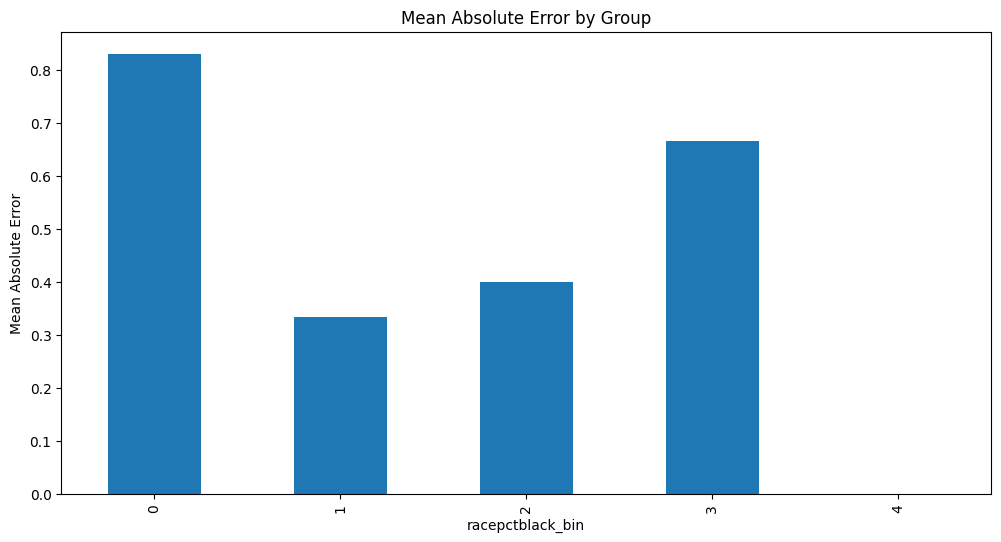

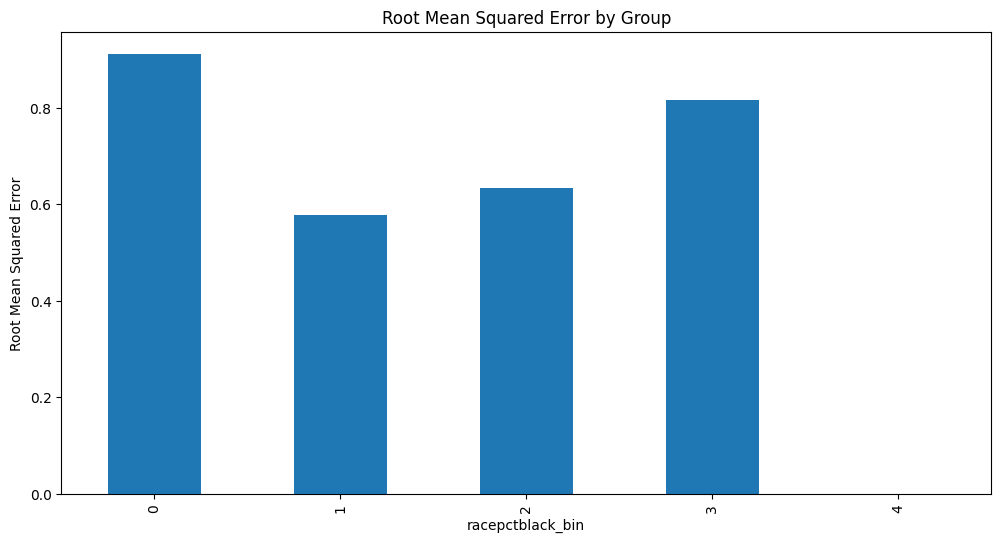

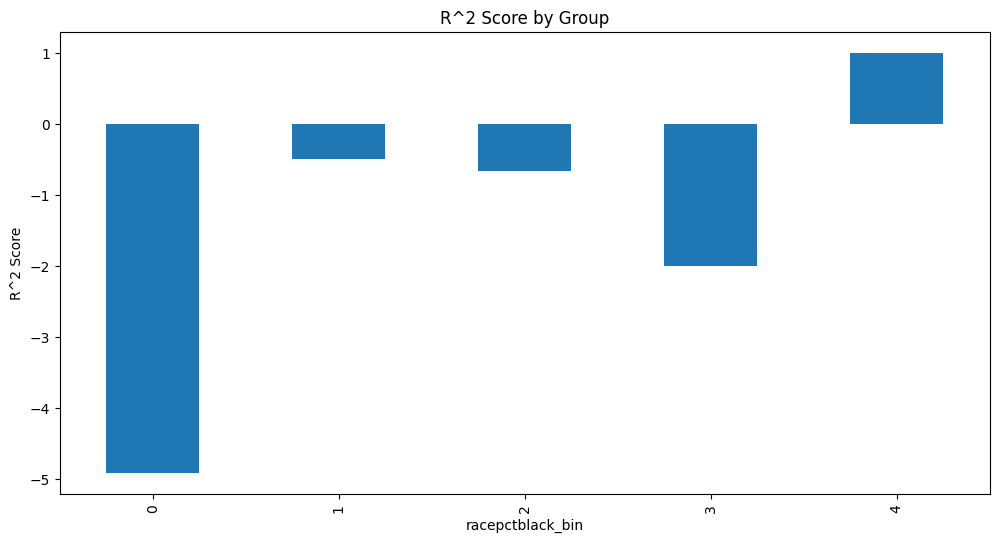

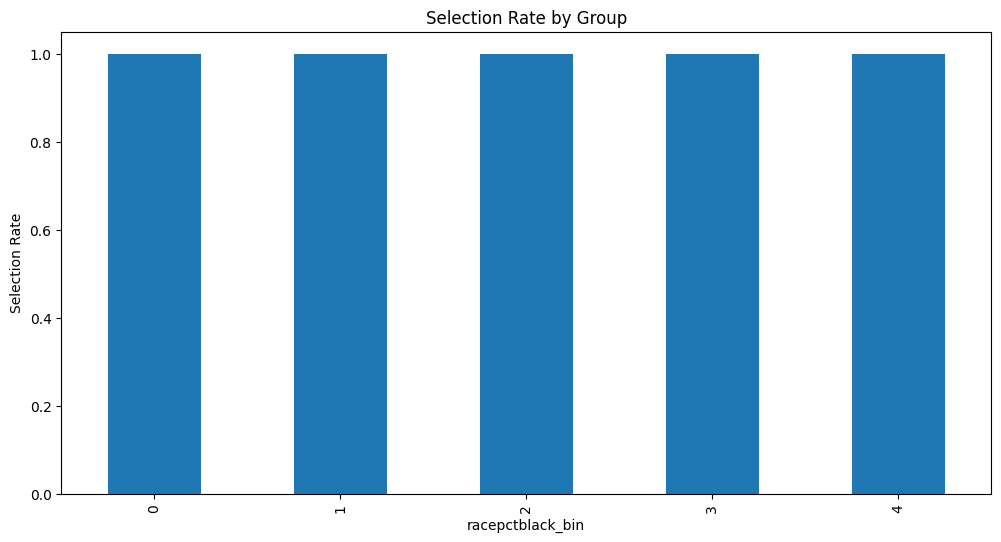

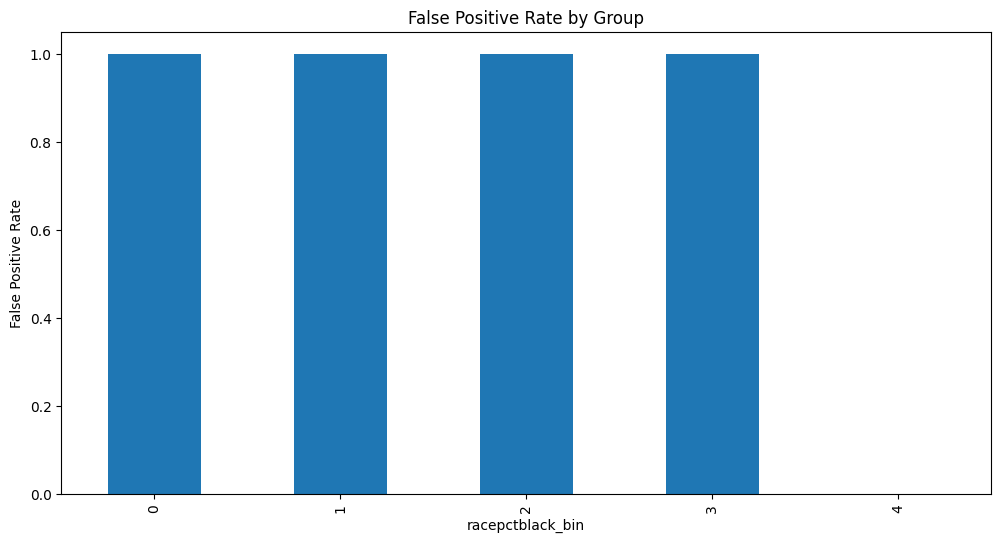

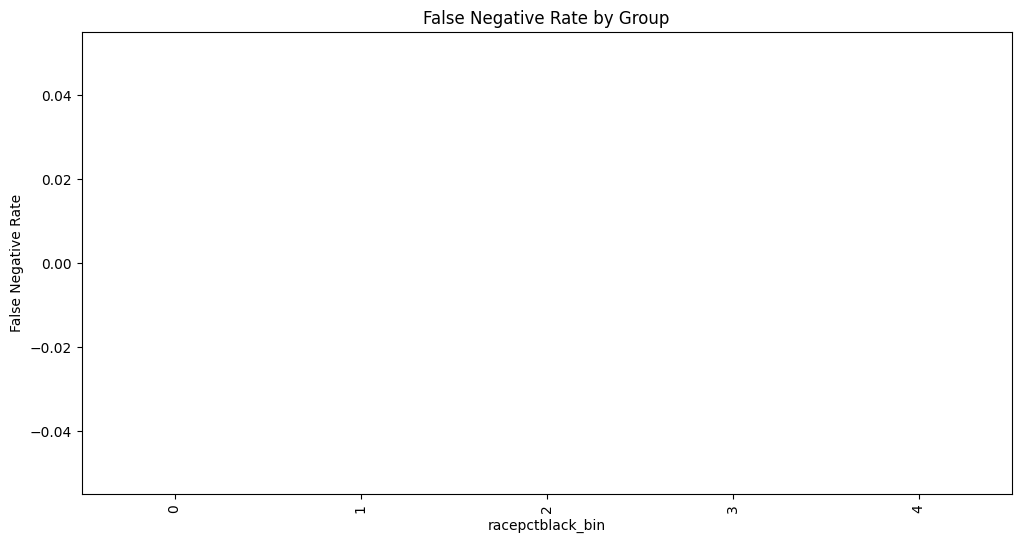

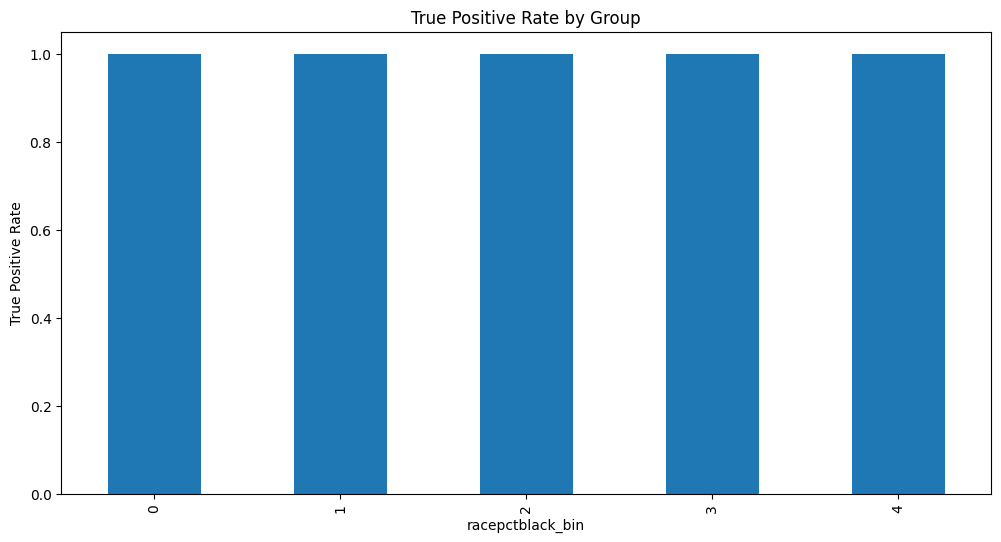

In [3]:
# Extract metrics for visualization
metrics_by_group = metrics.by_group.apply(pd.Series)
mae = metrics_by_group['mean_absolute_error']
rmse = metrics_by_group['root_mean_squared_error']
r2 = metrics_by_group['r2_score']
selection_rate = metrics_by_group['selection_rate']
fpr = metrics_by_group['false_positive_rate']
fnr = metrics_by_group['false_negative_rate']
tpr = metrics_by_group['true_positive_rate']

# Plot Mean Absolute Error by Group
mae.plot(kind='bar', figsize=(12, 6), title='Mean Absolute Error by Group')
plt.ylabel('Mean Absolute Error')
plt.show()

# Plot Root Mean Squared Error by Group
rmse.plot(kind='bar', figsize=(12, 6), title='Root Mean Squared Error by Group')
plt.ylabel('Root Mean Squared Error')
plt.show()

# Plot R^2 Score by Group
r2.plot(kind='bar', figsize=(12, 6), title='R^2 Score by Group')
plt.ylabel('R^2 Score')
plt.show()

# Plot Selection Rate by Group
selection_rate.plot(kind='bar', figsize=(12, 6), title='Selection Rate by Group')
plt.ylabel('Selection Rate')
plt.show()

# Plot False Positive Rate by Group
fpr.plot(kind='bar', figsize=(12, 6), title='False Positive Rate by Group')
plt.ylabel('False Positive Rate')
plt.show()

# Plot False Negative Rate by Group
fnr.plot(kind='bar', figsize=(12, 6), title='False Negative Rate by Group')
plt.ylabel('False Negative Rate')
plt.show()

# Plot True Positive Rate by Group
tpr.plot(kind='bar', figsize=(12, 6), title='True Positive Rate by Group')
plt.ylabel('True Positive Rate')
plt.show()


In [4]:
# Custom Metric Functions
def false_positive_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else np.nan

def false_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fn / (fn + tp) if (fn + tp) > 0 else np.nan

def selection_rate_custom(y_true, y_pred):
    return np.mean(y_pred)

def false_positive_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_positive_rate_custom(y_true[mask], y_pred[mask]))
    return np.nanmax(rates) - np.nanmin(rates)

def false_negative_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_negative_rate_custom(y_true[mask], y_pred[mask]))
    return np.nanmax(rates) - np.nanmin(rates)

def selection_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(selection_rate_custom(y_true[mask], y_pred[mask]))
    return np.nanmax(rates) - np.nanmin(rates)

# Define additional custom metrics
def false_omission_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fn / (fn + tn) if (fn + tn) > 0 else np.nan

def true_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else np.nan

def false_omission_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_omission_rate_custom(y_true[mask], y_pred[mask]))
    return np.nanmax(rates) - np.nanmin(rates)

def true_negative_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(true_negative_rate_custom(y_true[mask], y_pred[mask]))
    return np.nanmax(rates) - np.nanmin(rates)


In [5]:
# Calculate fairness metrics
dpd = demographic_parity_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])
eod = equalized_odds_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])
fprd = false_positive_rate_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])
fnrd = false_negative_rate_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])
srd = selection_rate_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])

# Summarize all fairness metrics
summary_metrics = {
    'Demographic Parity Difference': dpd,
    'Equalized Odds Difference': eod,
    'False Positive Rate Difference': fprd,
    'False Negative Rate Difference': fnrd,
    'Selection Rate Difference': srd,
    'False Omission Rate Difference': false_omission_rate_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'racepctblack_bin']),
    'True Negative Rate Difference': true_negative_rate_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])
}

print("\nSummary of Fairness Metrics:")
for metric, value in summary_metrics.items():
    print(f"{metric}: {value}")

# Reweighing Debiasing
# Manually perform reweighing
def compute_sample_weights(data, sensitive_features, target):
    df = data.copy()
    df['weight'] = 1.0
    # Calculate the prevalence of each group
    group_counts = df.groupby(sensitive_features).size()
    total_count = len(df)
    for group, count in group_counts.items():
        group_weight = total_count / (len(group_counts) * count)
        df.loc[df[sensitive_features] == group, 'weight'] = group_weight
    return df['weight']

# Compute sample weights for training data
sample_weights = compute_sample_weights(data.loc[X_train.index], 'racepctblack_bin', 'ViolentCrimesPerPop_binary')



Summary of Fairness Metrics:
Demographic Parity Difference: 0.0
Equalized Odds Difference: 1.0
False Positive Rate Difference: 0.0
False Negative Rate Difference: 0.0
Selection Rate Difference: 0.0
False Omission Rate Difference: nan
True Negative Rate Difference: 0.0


C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_8260\1494148550.py:52: RuntimeWarning: All-NaN axis encountered
  return np.nanmax(rates) - np.nanmin(rates)


In [6]:
# Train a Random Forest model on the reweighed data
rf_model_rw = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_rw.fit(X_train, y_train, sample_weight=sample_weights)

# Predict using the trained model
y_pred_rw = rf_model_rw.predict(X_test)
y_pred_rw_binary = (y_pred_rw > threshold).astype(int)

# Compute metrics for different groups
metrics_rw = MetricFrame(
    metrics={
        'mean_absolute_error': mean_absolute_error_metric,
        'root_mean_squared_error': root_mean_squared_error_metric,
        'r2_score': r2_score_metric,
        'selection_rate': selection_rate_metric,
        'false_positive_rate': false_positive_rate_metric,
        'false_negative_rate': false_negative_rate_metric,
        'true_positive_rate': true_positive_rate_metric
    },
    y_true=y_test,
    y_pred=y_pred_rw_binary,
    sensitive_features=data.loc[X_test.index, 'racepctblack_bin']
)

# Print the overall metrics
print("Overall Metrics after Reweighing:")
print(metrics_rw.overall)

# Print metrics by sensitive feature groups
print("\nMetrics by Sensitive Feature Groups after Reweighing:")
print(metrics_rw.by_group)


Overall Metrics after Reweighing:
mean_absolute_error        0.725275
root_mean_squared_error    0.851631
r2_score                  -2.640000
selection_rate             1.000000
false_positive_rate        1.000000
false_negative_rate        0.000000
true_positive_rate         1.000000
dtype: float64

Metrics by Sensitive Feature Groups after Reweighing:
                  mean_absolute_error  root_mean_squared_error  r2_score  \
racepctblack_bin                                                           
0                            0.830986                 0.911584 -4.916667   
1                            0.333333                 0.577350 -0.500000   
2                            0.400000                 0.632456 -0.666667   
3                            0.666667                 0.816497 -2.000000   
4                            0.000000                 0.000000  1.000000   

                  selection_rate  false_positive_rate  false_negative_rate  \
racepctblack_bin                 

C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the ro

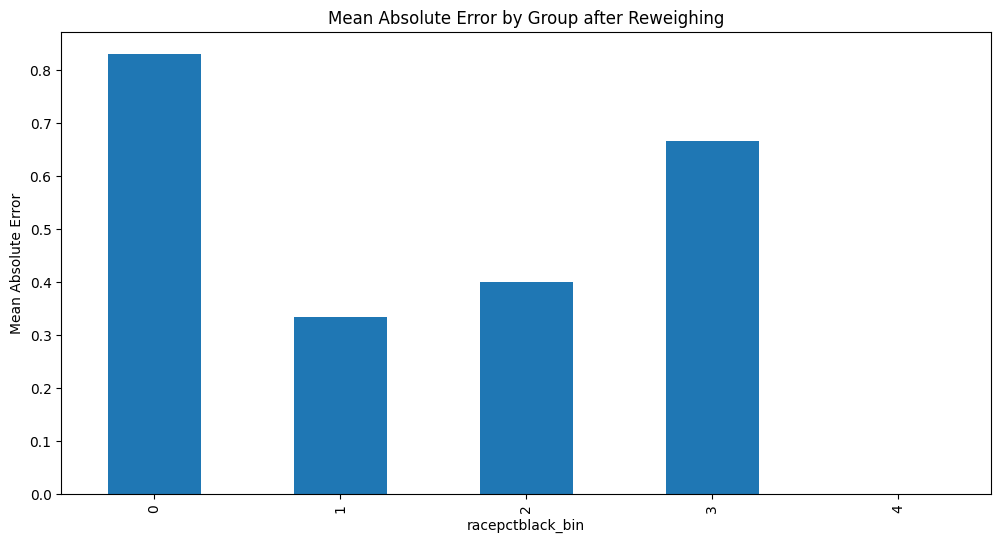

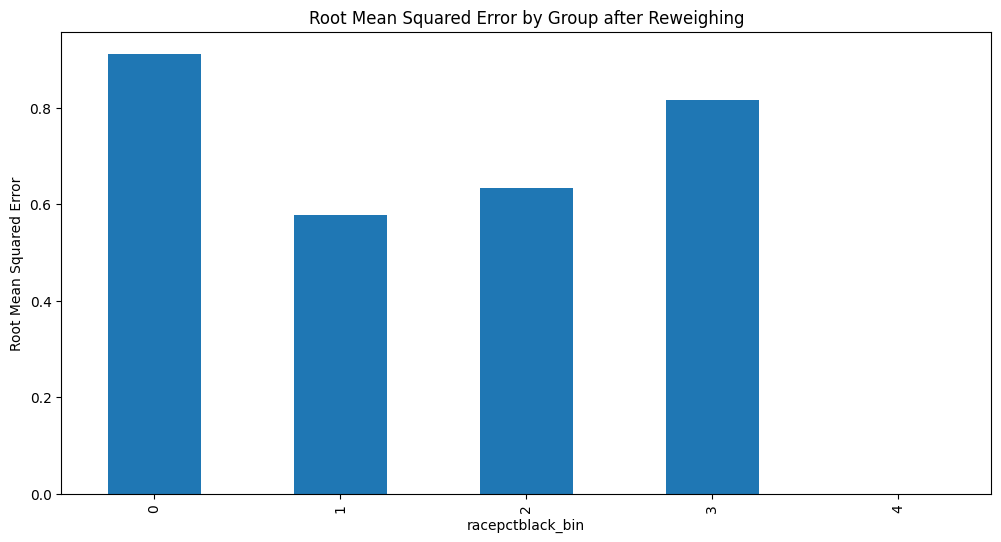

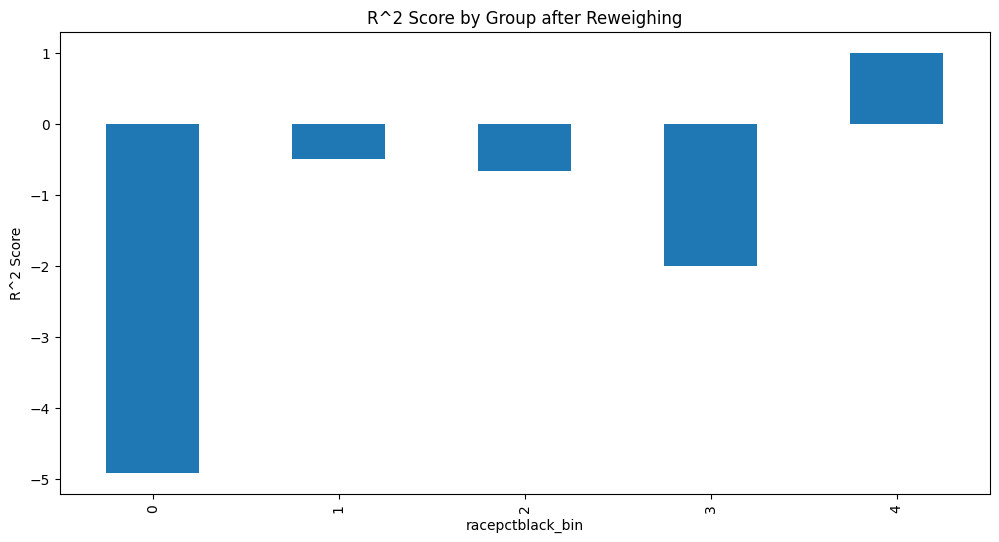

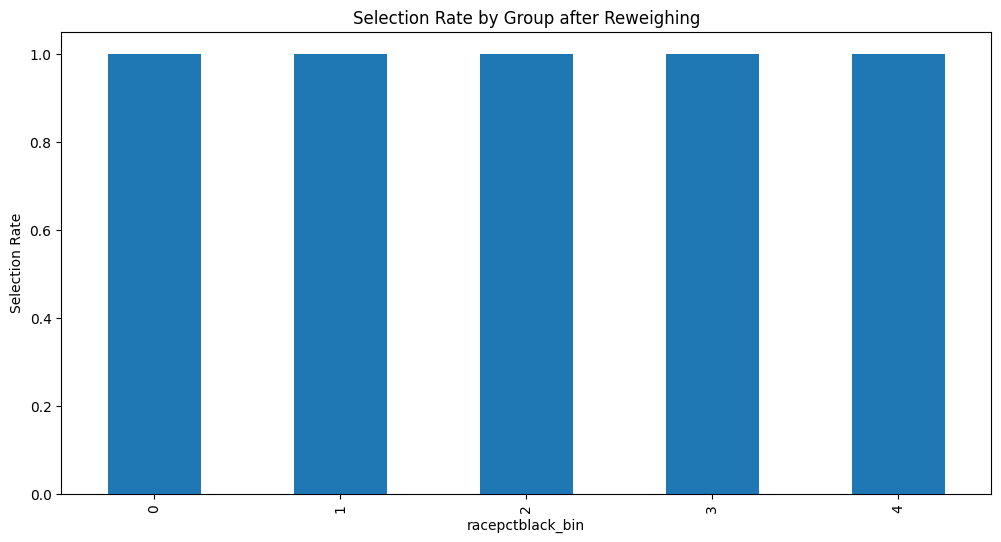

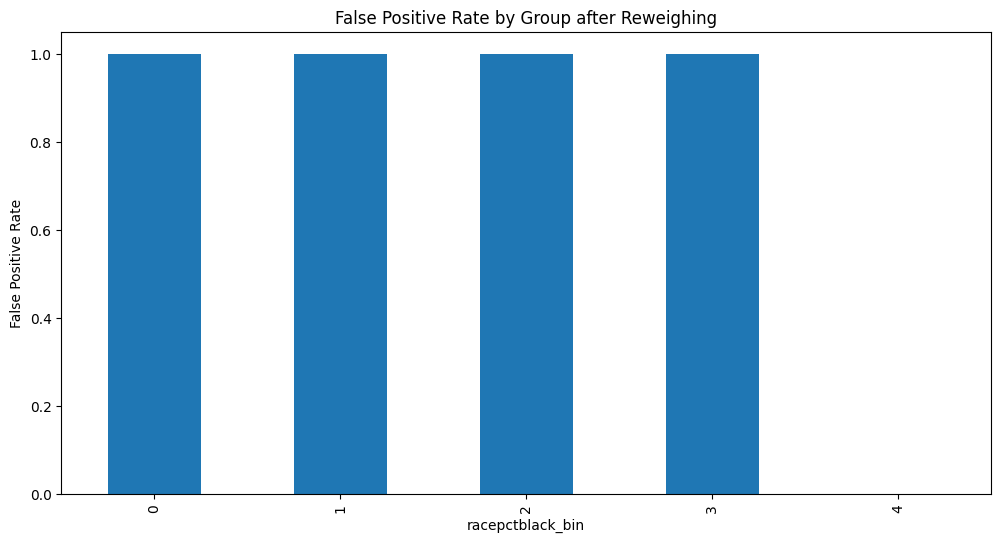

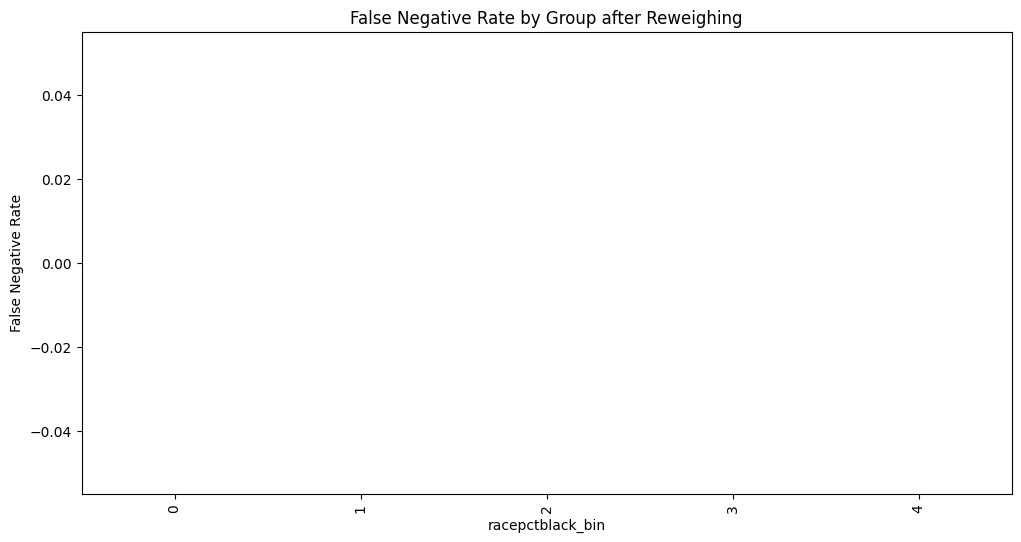

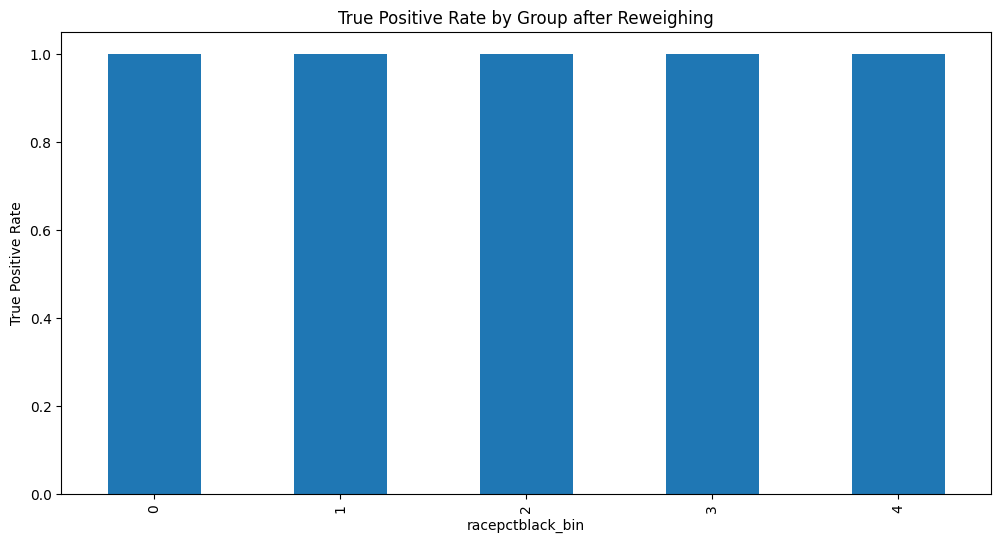

In [7]:
# Extract metrics for visualization
metrics_by_group_rw = metrics_rw.by_group.apply(pd.Series)
mae_rw = metrics_by_group_rw['mean_absolute_error']
rmse_rw = metrics_by_group_rw['root_mean_squared_error']
r2_rw = metrics_by_group_rw['r2_score']
selection_rate_rw = metrics_by_group_rw['selection_rate']
fpr_rw = metrics_by_group_rw['false_positive_rate']
fnr_rw = metrics_by_group_rw['false_negative_rate']
tpr_rw = metrics_by_group_rw['true_positive_rate']

# Plot Mean Absolute Error by Group after Reweighing
mae_rw.plot(kind='bar', figsize=(12, 6), title='Mean Absolute Error by Group after Reweighing')
plt.ylabel('Mean Absolute Error')
plt.show()

# Plot Root Mean Squared Error by Group after Reweighing
rmse_rw.plot(kind='bar', figsize=(12, 6), title='Root Mean Squared Error by Group after Reweighing')
plt.ylabel('Root Mean Squared Error')
plt.show()

# Plot R^2 Score by Group after Reweighing
r2_rw.plot(kind='bar', figsize=(12, 6), title='R^2 Score by Group after Reweighing')
plt.ylabel('R^2 Score')
plt.show()

# Plot Selection Rate by Group after Reweighing
selection_rate_rw.plot(kind='bar', figsize=(12, 6), title='Selection Rate by Group after Reweighing')
plt.ylabel('Selection Rate')
plt.show()

# Plot False Positive Rate by Group after Reweighing
fpr_rw.plot(kind='bar', figsize=(12, 6), title='False Positive Rate by Group after Reweighing')
plt.ylabel('False Positive Rate')
plt.show()

# Plot False Negative Rate by Group after Reweighing
fnr_rw.plot(kind='bar', figsize=(12, 6), title='False Negative Rate by Group after Reweighing')
plt.ylabel('False Negative Rate')
plt.show()

# Plot True Positive Rate by Group after Reweighing
tpr_rw.plot(kind='bar', figsize=(12, 6), title='True Positive Rate by Group after Reweighing')
plt.ylabel('True Positive Rate')
plt.show()


In [8]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

# Adversarial Debiasing using Exponentiated Gradient Reduction
mitigator = ExponentiatedGradient(estimator=RandomForestClassifier(random_state=42), 
                                  constraints=DemographicParity())

mitigator.fit(X_train, y_train, sensitive_features=data.loc[X_train.index, 'racepctblack_bin'])

y_pred_ad = mitigator.predict(X_test)
y_pred_ad_binary = (y_pred_ad > threshold).astype(int)

# Compute metrics for different groups
metrics_ad = MetricFrame(
    metrics={
        'mean_absolute_error': mean_absolute_error_metric,
        'root_mean_squared_error': root_mean_squared_error_metric,
        'r2_score': r2_score_metric,
        'selection_rate': selection_rate_metric,
        'false_positive_rate': false_positive_rate_metric,
        'false_negative_rate': false_negative_rate_metric,
        'true_positive_rate': true_positive_rate_metric
    },
    y_true=y_test,
    y_pred=y_pred_ad_binary,
    sensitive_features=data.loc[X_test.index, 'racepctblack_bin']
)

# Print the overall metrics
print("Overall Metrics after Adversarial Debiasing:")
print(metrics_ad.overall)

# Print metrics by sensitive feature groups
print("\nMetrics by Sensitive Feature Groups after Adversarial Debiasing:")
print(metrics_ad.by_group)


C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  s

Overall Metrics after Adversarial Debiasing:
mean_absolute_error        0.725275
root_mean_squared_error    0.851631
r2_score                  -2.640000
selection_rate             1.000000
false_positive_rate        1.000000
false_negative_rate        0.000000
true_positive_rate         1.000000
dtype: float64

Metrics by Sensitive Feature Groups after Adversarial Debiasing:
                  mean_absolute_error  root_mean_squared_error  r2_score  \
racepctblack_bin                                                           
0                            0.830986                 0.911584 -4.916667   
1                            0.333333                 0.577350 -0.500000   
2                            0.400000                 0.632456 -0.666667   
3                            0.666667                 0.816497 -2.000000   
4                            0.000000                 0.000000  1.000000   

                  selection_rate  false_positive_rate  false_negative_rate  \
racepctblac

C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the ro

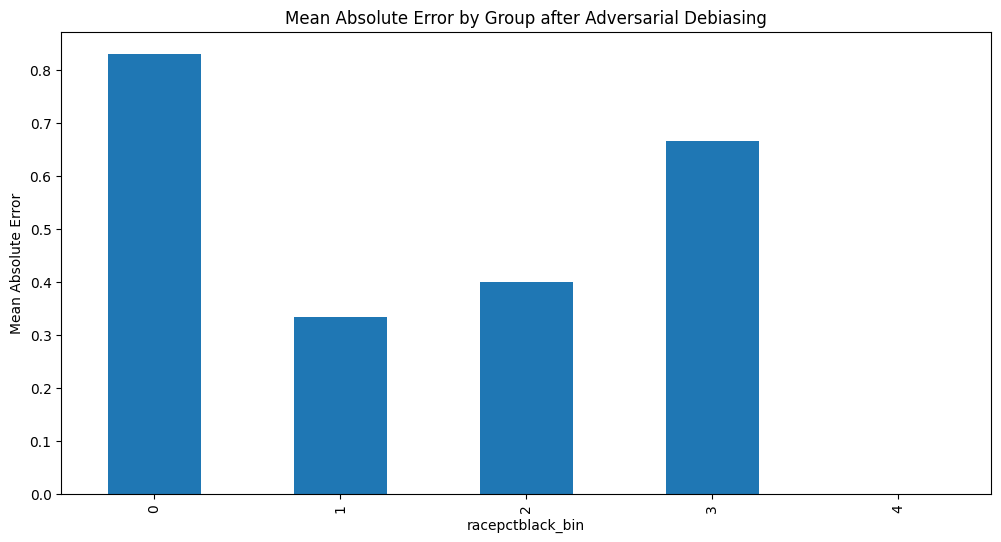

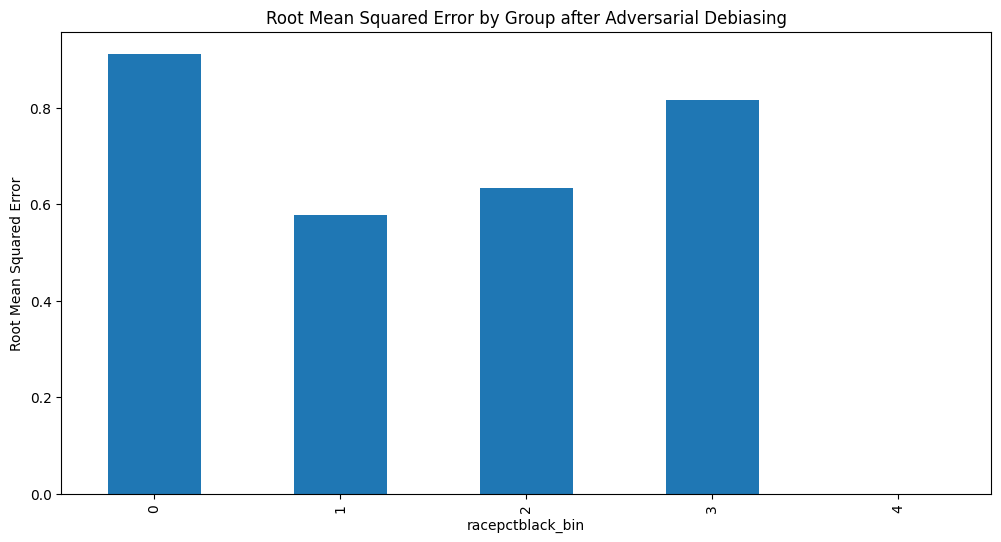

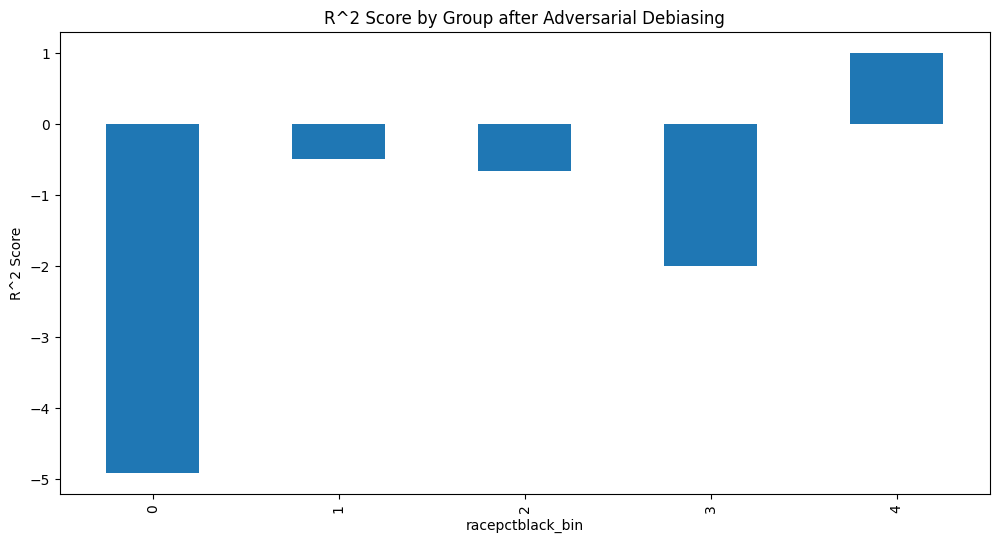

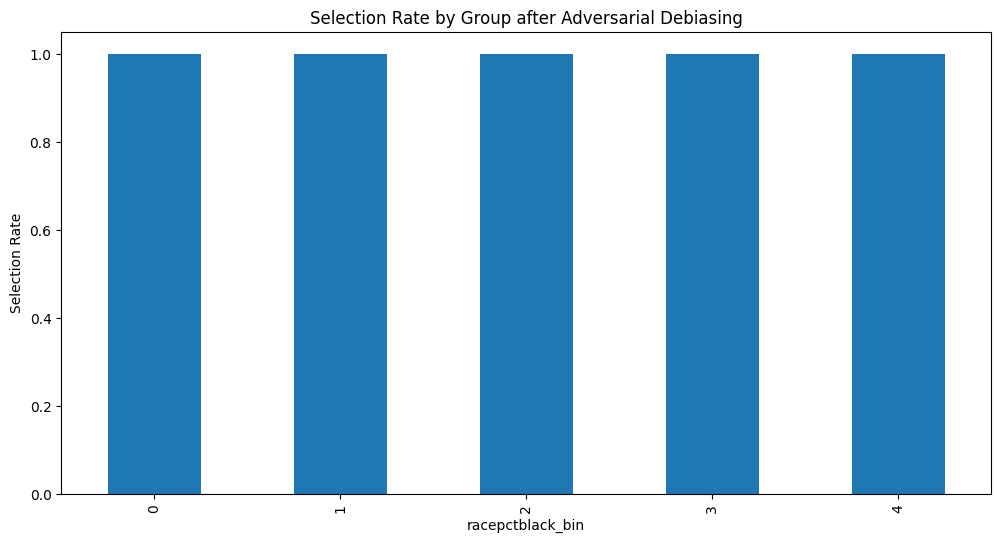

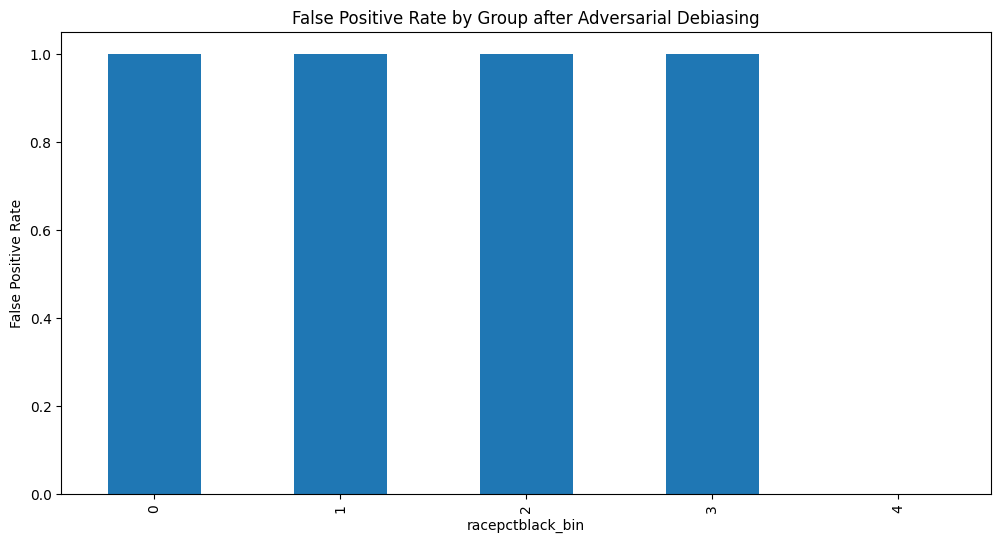

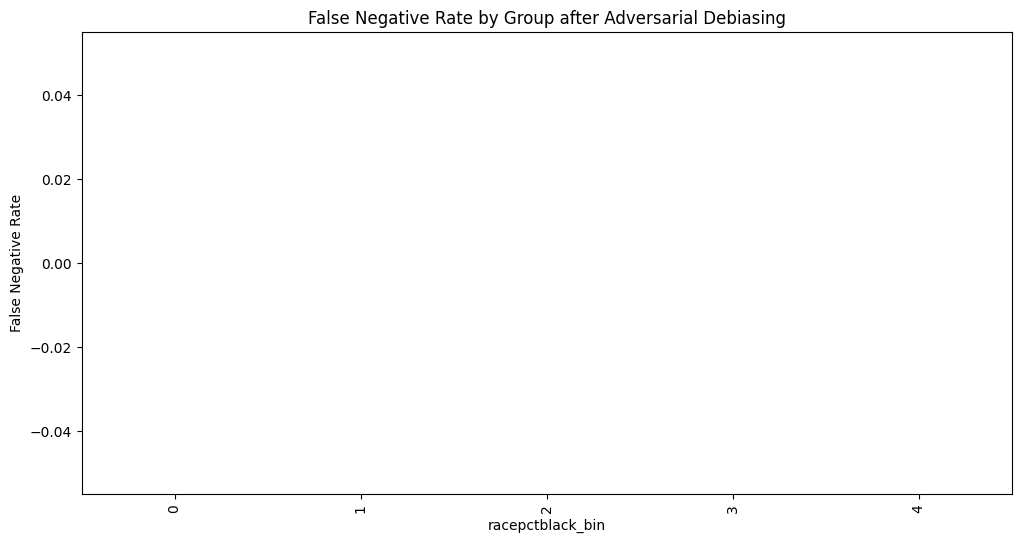

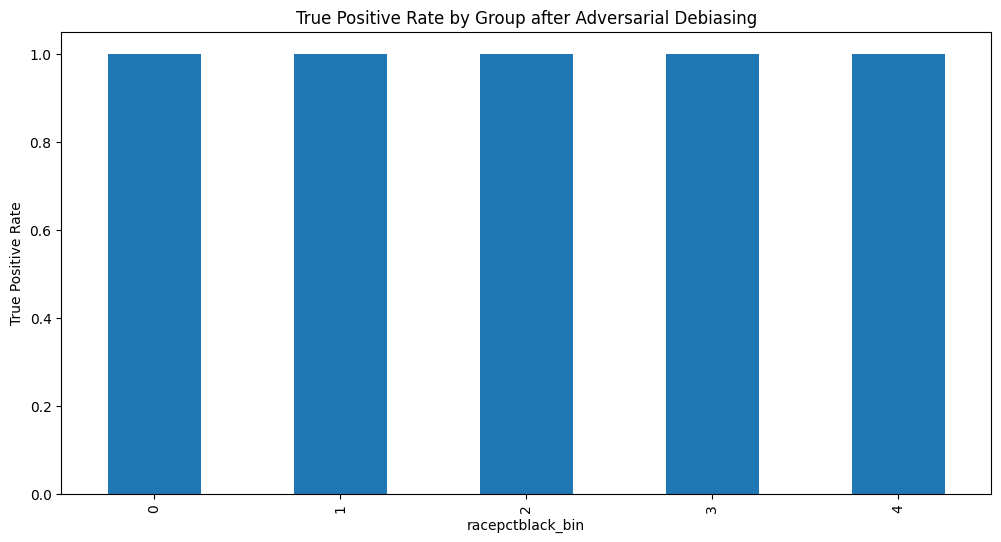

In [9]:
# Extract metrics for visualization
metrics_by_group_ad = metrics_ad.by_group.apply(pd.Series)
mae_ad = metrics_by_group_ad['mean_absolute_error']
rmse_ad = metrics_by_group_ad['root_mean_squared_error']
r2_ad = metrics_by_group_ad['r2_score']
selection_rate_ad = metrics_by_group_ad['selection_rate']
fpr_ad = metrics_by_group_ad['false_positive_rate']
fnr_ad = metrics_by_group_ad['false_negative_rate']
tpr_ad = metrics_by_group_ad['true_positive_rate']

# Plot Mean Absolute Error by Group after Adversarial Debiasing
mae_ad.plot(kind='bar', figsize=(12, 6), title='Mean Absolute Error by Group after Adversarial Debiasing')
plt.ylabel('Mean Absolute Error')
plt.show()

# Plot Root Mean Squared Error by Group after Adversarial Debiasing
rmse_ad.plot(kind='bar', figsize=(12, 6), title='Root Mean Squared Error by Group after Adversarial Debiasing')
plt.ylabel('Root Mean Squared Error')
plt.show()

# Plot R^2 Score by Group after Adversarial Debiasing
r2_ad.plot(kind='bar', figsize=(12, 6), title='R^2 Score by Group after Adversarial Debiasing')
plt.ylabel('R^2 Score')
plt.show()

# Plot Selection Rate by Group after Adversarial Debiasing
selection_rate_ad.plot(kind='bar', figsize=(12, 6), title='Selection Rate by Group after Adversarial Debiasing')
plt.ylabel('Selection Rate')
plt.show()

# Plot False Positive Rate by Group after Adversarial Debiasing
fpr_ad.plot(kind='bar', figsize=(12, 6), title='False Positive Rate by Group after Adversarial Debiasing')
plt.ylabel('False Positive Rate')
plt.show()

# Plot False Negative Rate by Group after Adversarial Debiasing
fnr_ad.plot(kind='bar', figsize=(12, 6), title='False Negative Rate by Group after Adversarial Debiasing')
plt.ylabel('False Negative Rate')
plt.show()

# Plot True Positive Rate by Group after Adversarial Debiasing
tpr_ad.plot(kind='bar', figsize=(12, 6), title='True Positive Rate by Group after Adversarial Debiasing')
plt.ylabel('True Positive Rate')
plt.show()



In [10]:
from fairlearn.postprocessing import ThresholdOptimizer
# Perform post-processing using ThresholdOptimizer
postprocess_est = ThresholdOptimizer(estimator=rf_model, 
                                     constraints="equalized_odds", 
                                     prefit=True)

postprocess_est.fit(X_train, y_train, sensitive_features=data.loc[X_train.index, 'racepctblack_bin'])

y_pred_pp = postprocess_est.predict(X_test, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])

# Compute metrics for different groups
metrics_pp = MetricFrame(
    metrics={
        'mean_absolute_error': mean_absolute_error_metric,
        'root_mean_squared_error': root_mean_squared_error_metric,
        'r2_score': r2_score_metric,
        'selection_rate': selection_rate_metric,
        'false_positive_rate': false_positive_rate_metric,
        'false_negative_rate': false_negative_rate_metric,
        'true_positive_rate': true_positive_rate_metric
    },
    y_true=y_test,
    y_pred=y_pred_pp,
    sensitive_features=data.loc[X_test.index, 'racepctblack_bin']
)

# Print the overall metrics
print("Overall Metrics after Post-processing:")
print(metrics_pp.overall)

# Print metrics by sensitive feature groups
print("\nMetrics by Sensitive Feature Groups after Post-processing:")
print(metrics_pp.by_group)


C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fairlearn\postprocessing\_threshold_optimizer.py:288: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(
C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Fujitsu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' 

Overall Metrics after Post-processing:
mean_absolute_error        0.197802
root_mean_squared_error    0.444750
r2_score                   0.007273
selection_rate             0.318681
false_positive_rate        0.166667
false_negative_rate        0.280000
true_positive_rate         0.720000
dtype: float64

Metrics by Sensitive Feature Groups after Post-processing:
                  mean_absolute_error  root_mean_squared_error  r2_score  \
racepctblack_bin                                                           
0                            0.183099                 0.427900 -0.303672   
1                            0.333333                 0.577350 -0.500000   
2                            0.200000                 0.447214  0.166667   
3                            0.333333                 0.577350 -0.500000   
4                            0.000000                 0.000000  1.000000   

                  selection_rate  false_positive_rate  false_negative_rate  \
racepctblack_bin       

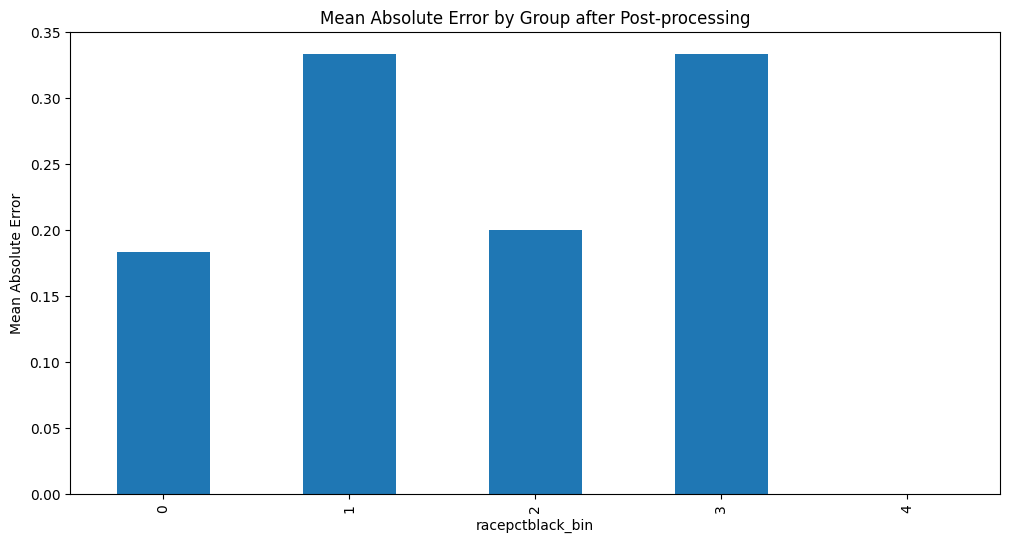

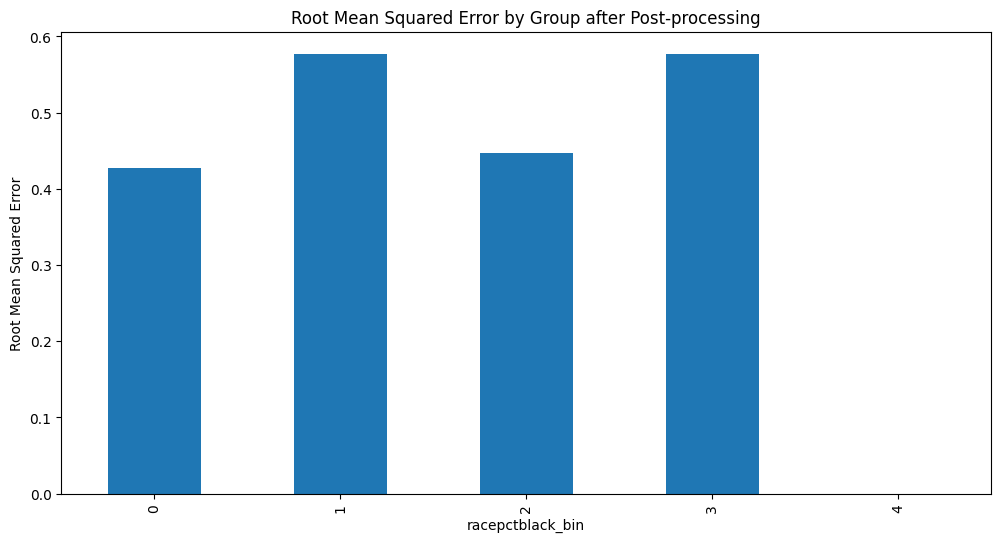

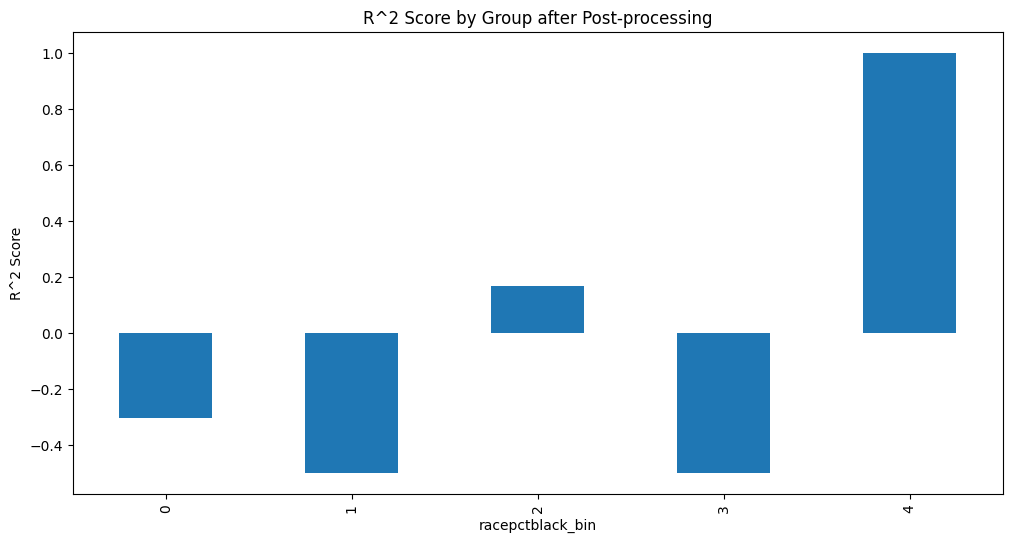

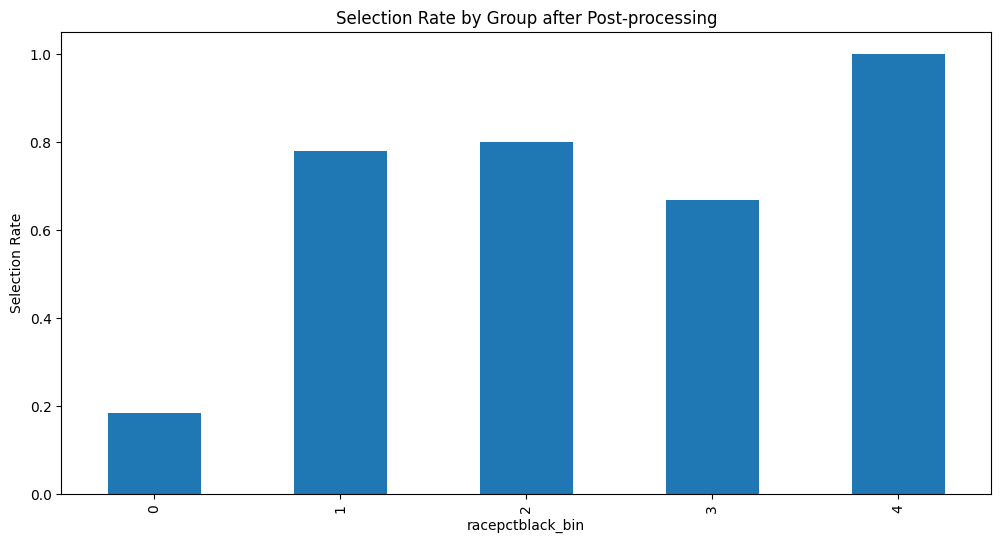

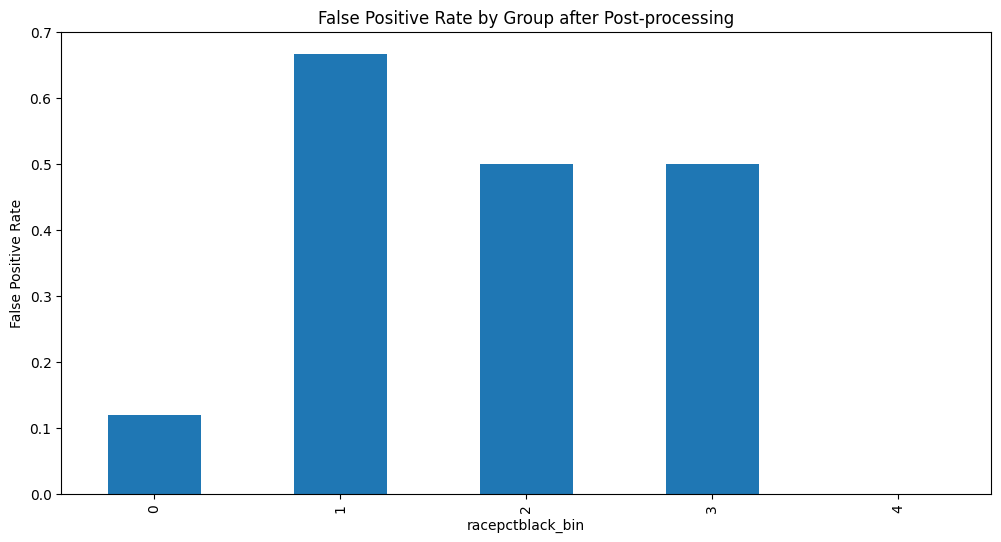

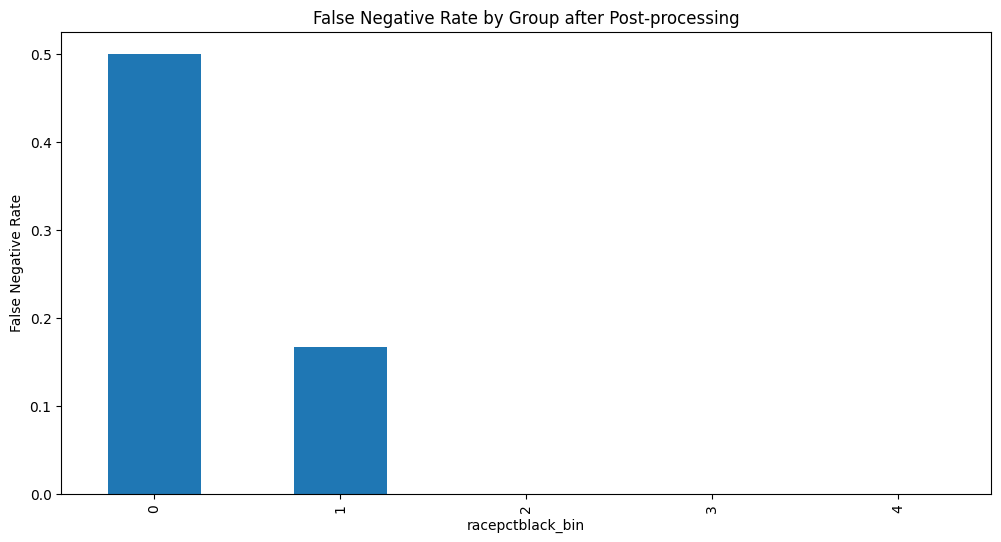

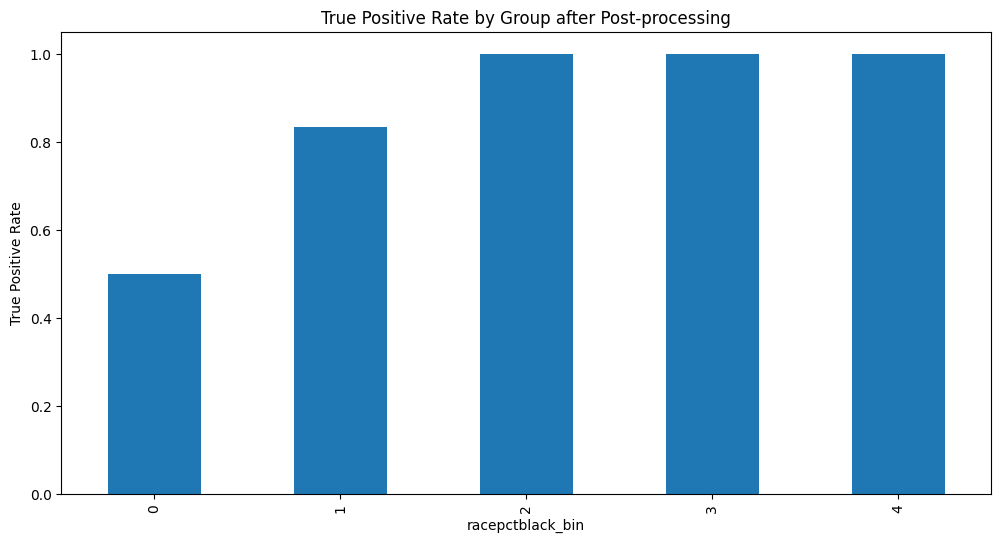

In [11]:
# Extract metrics for visualization
metrics_by_group_pp = metrics_pp.by_group.apply(pd.Series)
mae_pp = metrics_by_group_pp['mean_absolute_error']
rmse_pp = metrics_by_group_pp['root_mean_squared_error']
r2_pp = metrics_by_group_pp['r2_score']
selection_rate_pp = metrics_by_group_pp['selection_rate']
fpr_pp = metrics_by_group_pp['false_positive_rate']
fnr_pp = metrics_by_group_pp['false_negative_rate']
tpr_pp = metrics_by_group_pp['true_positive_rate']

# Plot Mean Absolute Error by Group after Post-processing
mae_pp.plot(kind='bar', figsize=(12, 6), title='Mean Absolute Error by Group after Post-processing')
plt.ylabel('Mean Absolute Error')
plt.show()

# Plot Root Mean Squared Error by Group after Post-processing
rmse_pp.plot(kind='bar', figsize=(12, 6), title='Root Mean Squared Error by Group after Post-processing')
plt.ylabel('Root Mean Squared Error')
plt.show()

# Plot R^2 Score by Group after Post-processing
r2_pp.plot(kind='bar', figsize=(12, 6), title='R^2 Score by Group after Post-processing')
plt.ylabel('R^2 Score')
plt.show()

# Plot Selection Rate by Group after Post-processing
selection_rate_pp.plot(kind='bar', figsize=(12, 6), title='Selection Rate by Group after Post-processing')
plt.ylabel('Selection Rate')
plt.show()

# Plot False Positive Rate by Group after Post-processing
fpr_pp.plot(kind='bar', figsize=(12, 6), title='False Positive Rate by Group after Post-processing')
plt.ylabel('False Positive Rate')
plt.show()

# Plot False Negative Rate by Group after Post-processing
fnr_pp.plot(kind='bar', figsize=(12, 6), title='False Negative Rate by Group after Post-processing')
plt.ylabel('False Negative Rate')
plt.show()

# Plot True Positive Rate by Group after Post-processing
tpr_pp.plot(kind='bar', figsize=(12, 6), title='True Positive Rate by Group after Post-processing')
plt.ylabel('True Positive Rate')
plt.show()


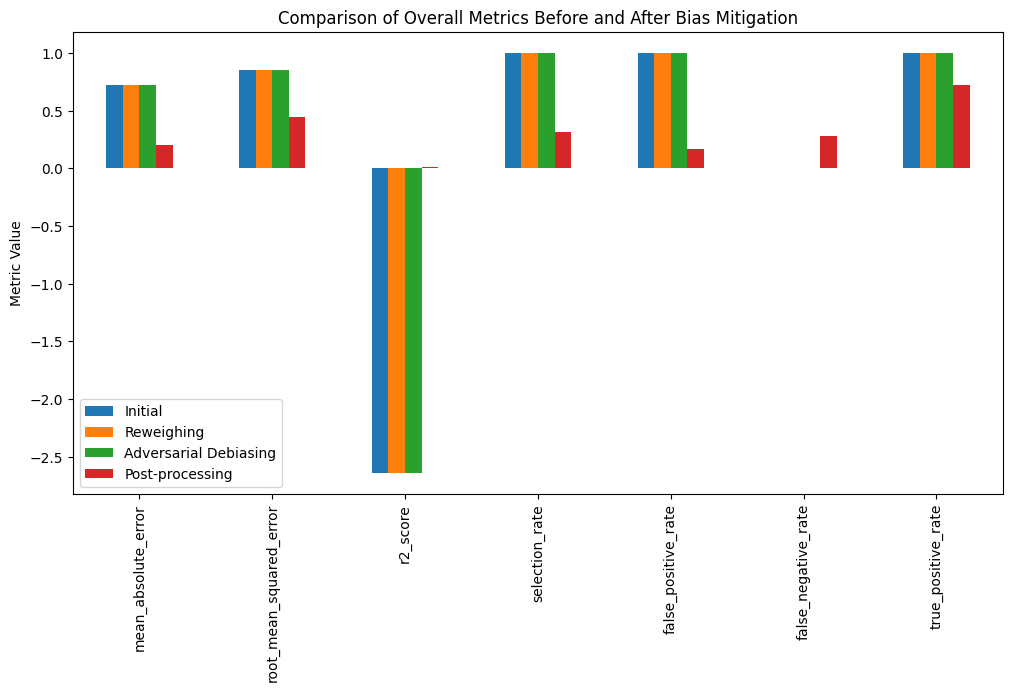

In [12]:
# Comparison of results before and after bias mitigation

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Initial': metrics.overall,
    'Reweighing': metrics_rw.overall,
    'Adversarial Debiasing': metrics_ad.overall,
    'Post-processing': metrics_pp.overall
})

# Plot comparison
comparison_df.plot(kind='bar', figsize=(12, 6), title='Comparison of Overall Metrics Before and After Bias Mitigation')
plt.ylabel('Metric Value')
plt.show()

import matplotlib.pyplot as plt

# Function to plot comparison of metrics for different mitigation steps
def plot_metric_comparison(metrics_initial, metrics_rw, metrics_ad, metrics_pp, metric_name, ylabel, title):
    labels = metrics_initial.index

    x = np.arange(len(labels))
    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width * 1.5, metrics_initial[metric_name], width, label='Initial')
    rects2 = ax.bar(x - width / 2, metrics_rw[metric_name], width, label='Reweighing')
    rects3 = ax.bar(x + width / 2, metrics_ad[metric_name], width, label='Adversarial Debiasing')
    rects4 = ax.bar(x + width * 1.5, metrics_pp[metric_name], width, label='Post-processing')

    ax.set_xlabel('Groups')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()

    plt.show()

# Extracting overall metrics
overall_metrics_initial = metrics.overall
overall_metrics_rw = metrics_rw.overall
overall_metrics_ad = metrics_ad.overall
overall_metrics_pp = metrics_pp.overall


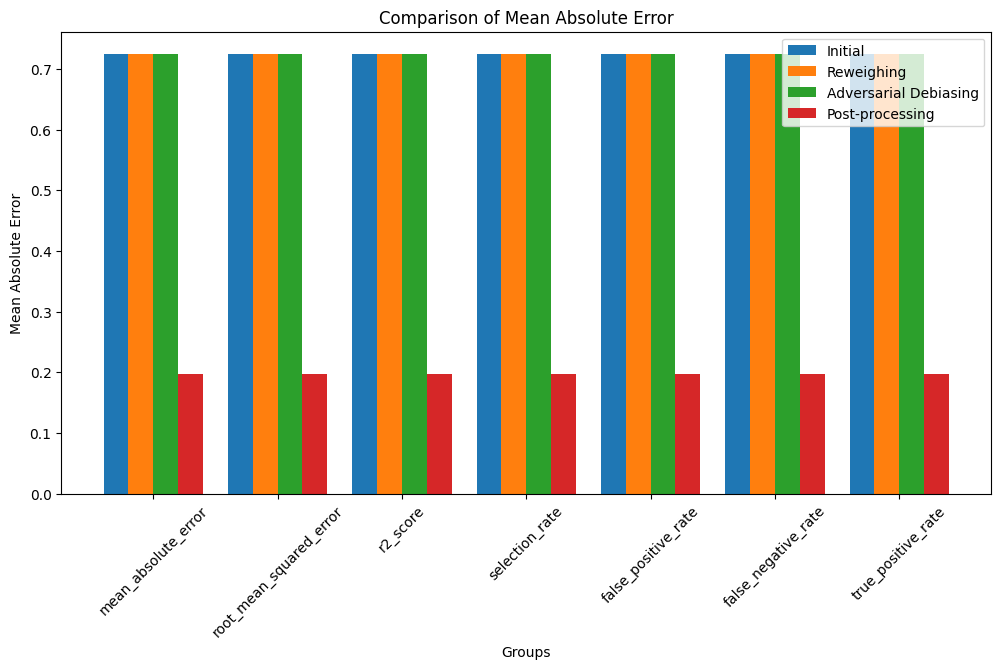

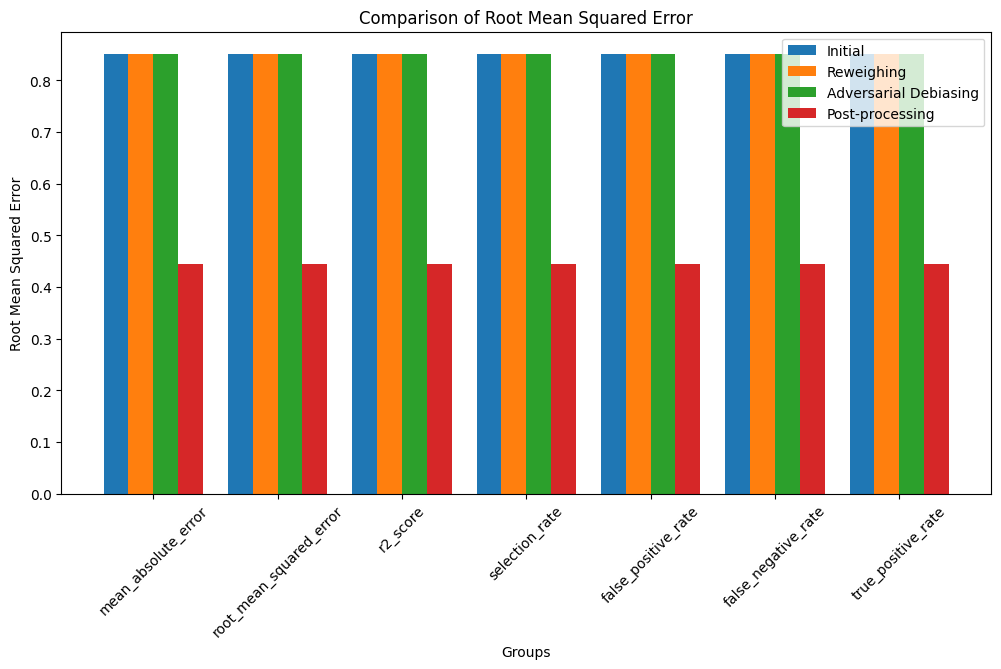

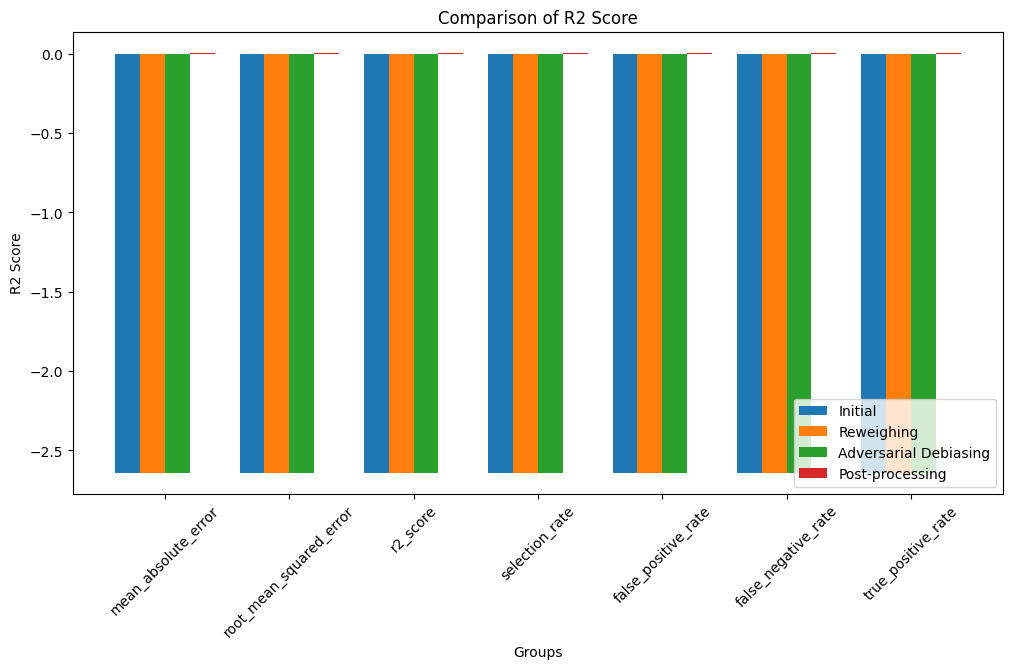

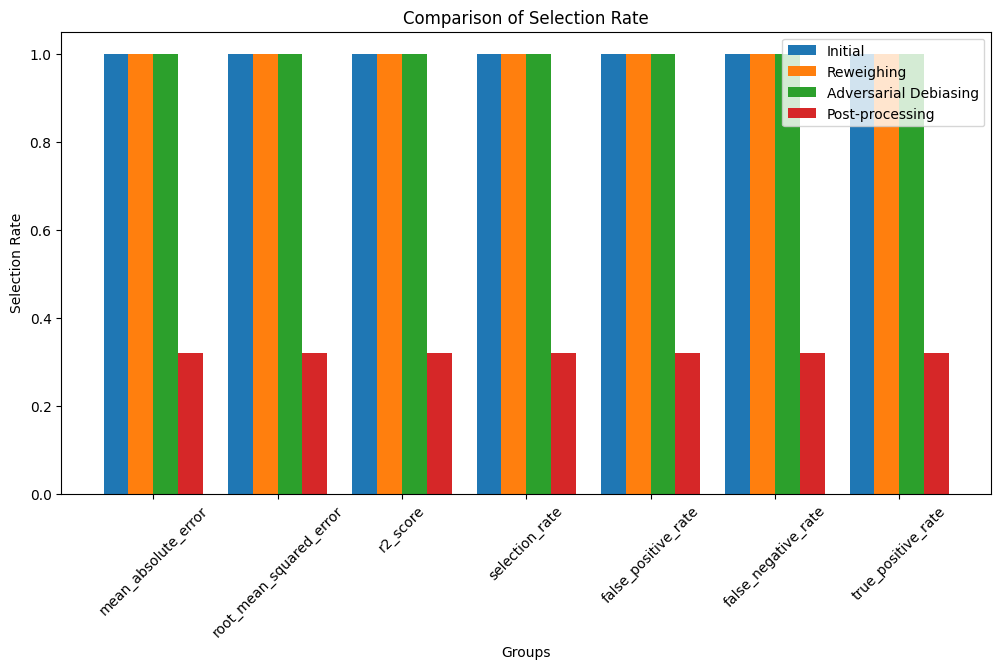

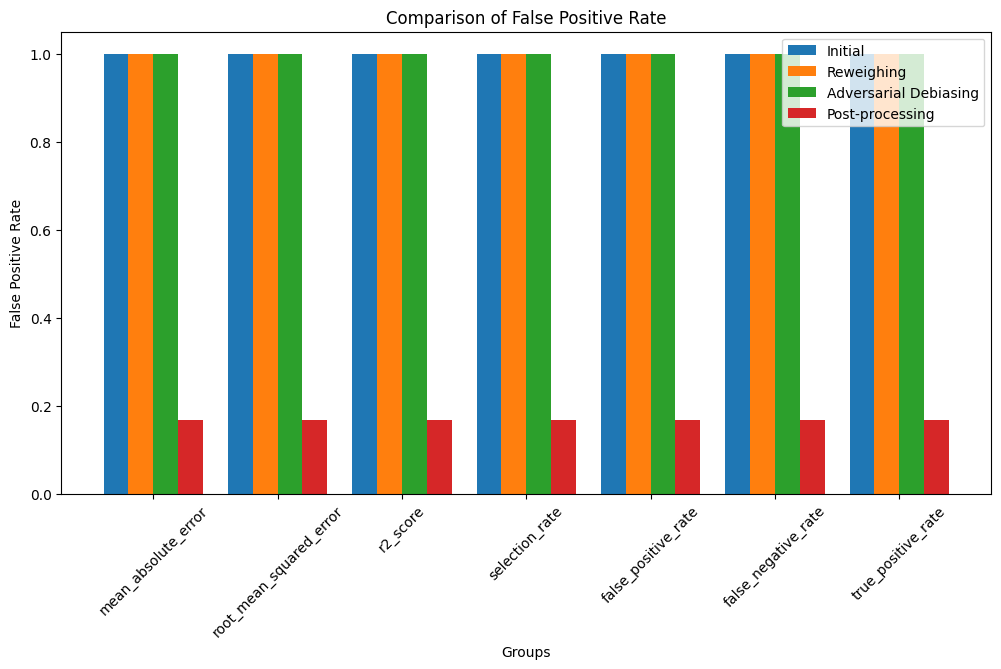

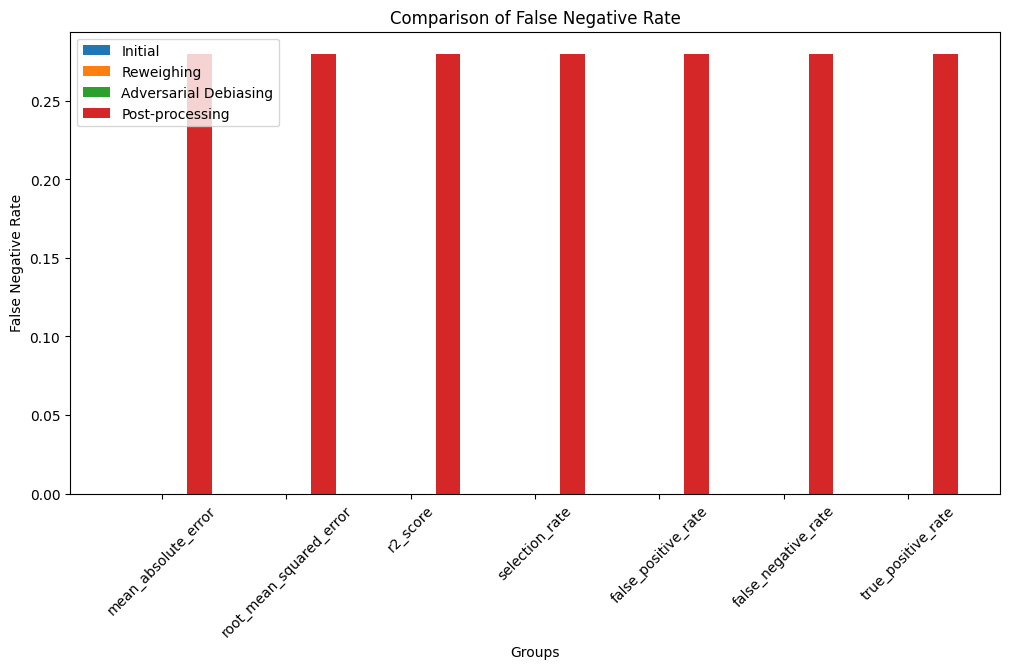

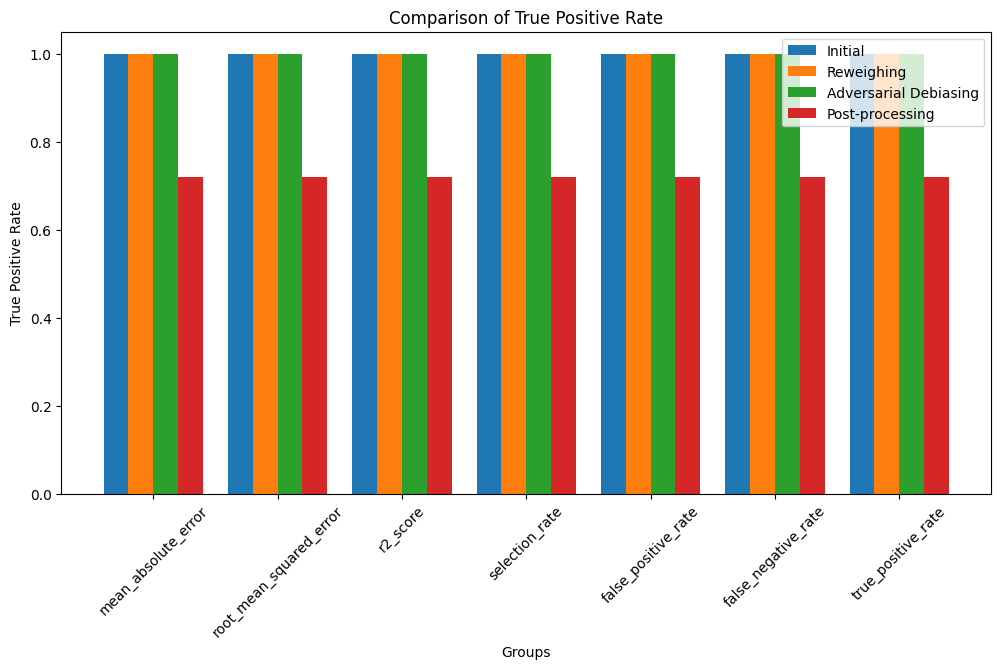

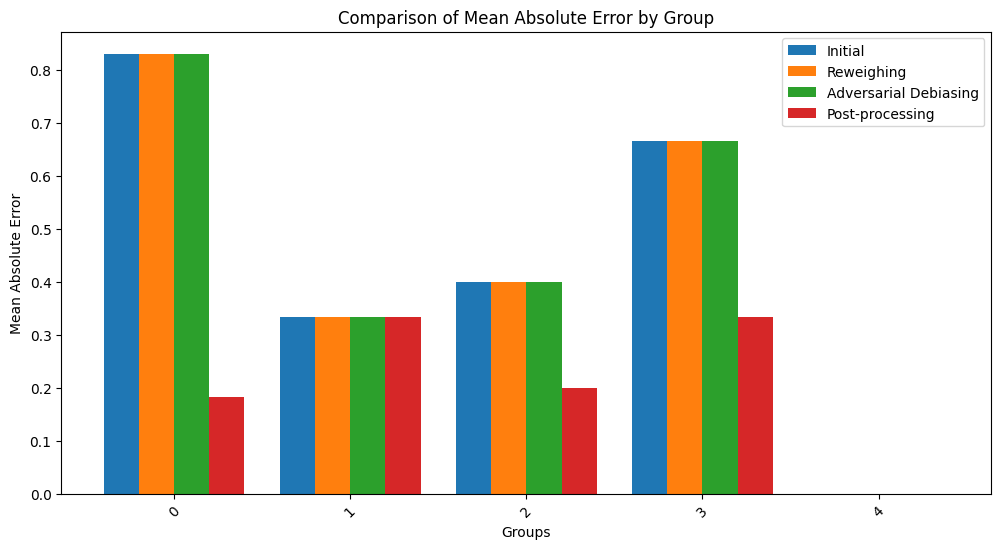

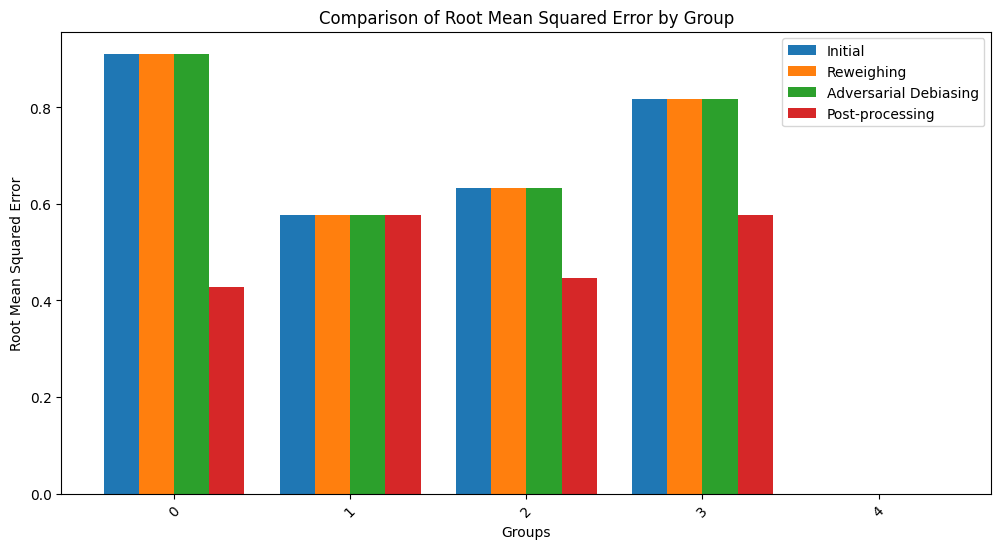

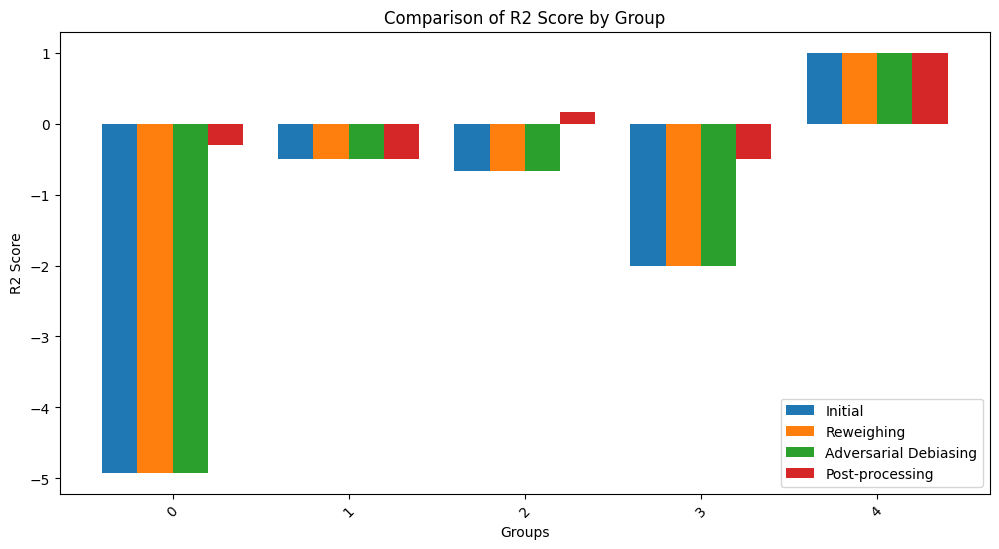

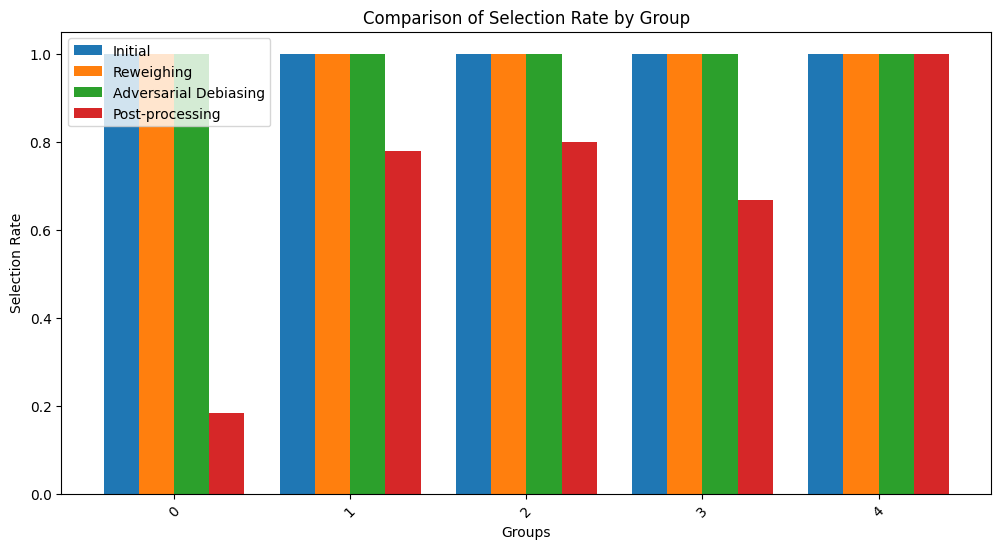

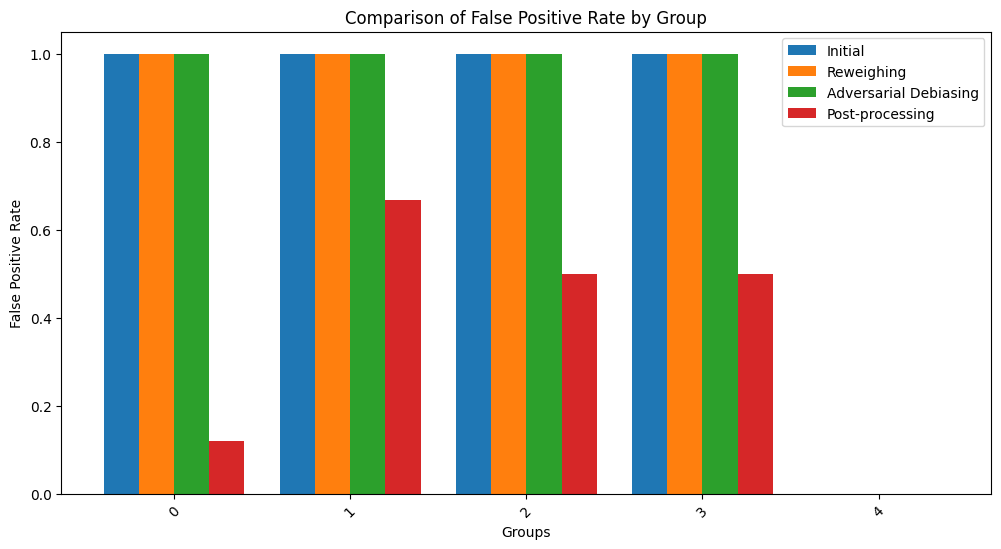

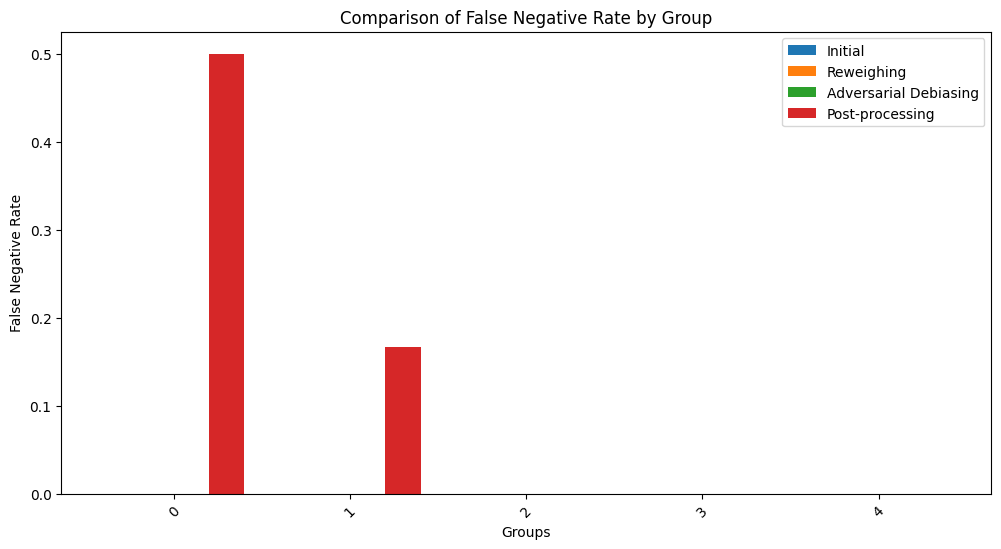

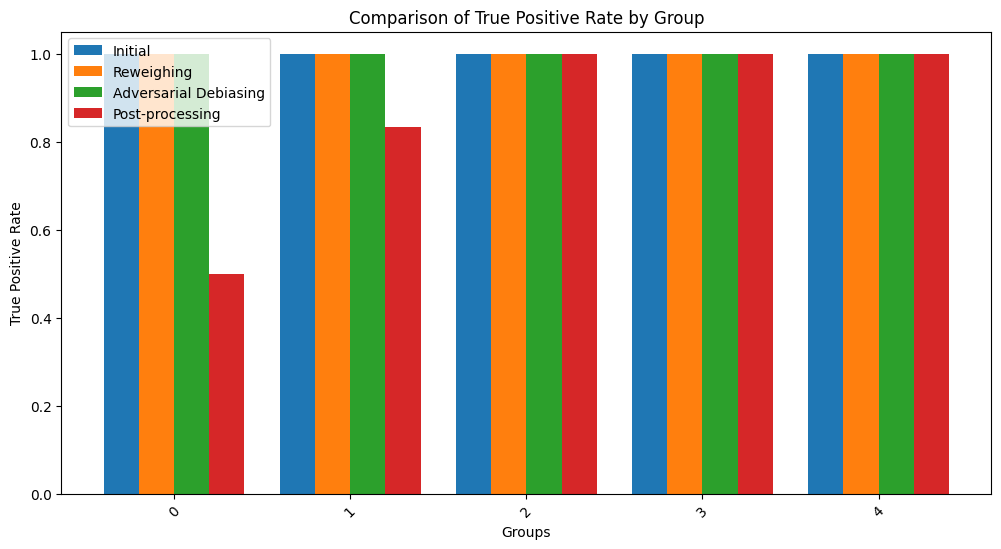

In [13]:
# Plot overall metrics comparison
def plot_overall_metric_comparison():
    metric_names = ['mean_absolute_error', 'root_mean_squared_error', 'r2_score', 'selection_rate', 
                    'false_positive_rate', 'false_negative_rate', 'true_positive_rate']
    for metric in metric_names:
        plot_metric_comparison(
            overall_metrics_initial, overall_metrics_rw, overall_metrics_ad, overall_metrics_pp, 
            metric, metric.replace('_', ' ').title(), f'Comparison of {metric.replace("_", " ").title()}'
        )

# Plot overall metric comparison
plot_overall_metric_comparison()

# Plot metrics by group comparison
def plot_metrics_by_group_comparison(metrics_by_group_initial, metrics_by_group_rw, metrics_by_group_ad, metrics_by_group_pp):
    metric_names = ['mean_absolute_error', 'root_mean_squared_error', 'r2_score', 'selection_rate', 
                    'false_positive_rate', 'false_negative_rate', 'true_positive_rate']
    for metric in metric_names:
        plot_metric_comparison(
            metrics_by_group_initial, metrics_by_group_rw, metrics_by_group_ad, metrics_by_group_pp, 
            metric, metric.replace('_', ' ').title(), f'Comparison of {metric.replace("_", " ").title()} by Group'
        )

# Extracting metrics by group
metrics_by_group_initial = metrics.by_group.apply(pd.Series)
metrics_by_group_rw = metrics_rw.by_group.apply(pd.Series)
metrics_by_group_ad = metrics_ad.by_group.apply(pd.Series)
metrics_by_group_pp = metrics_pp.by_group.apply(pd.Series)

# Plot metrics by group comparison
plot_metrics_by_group_comparison(metrics_by_group_initial, metrics_by_group_rw, metrics_by_group_ad, metrics_by_group_pp)


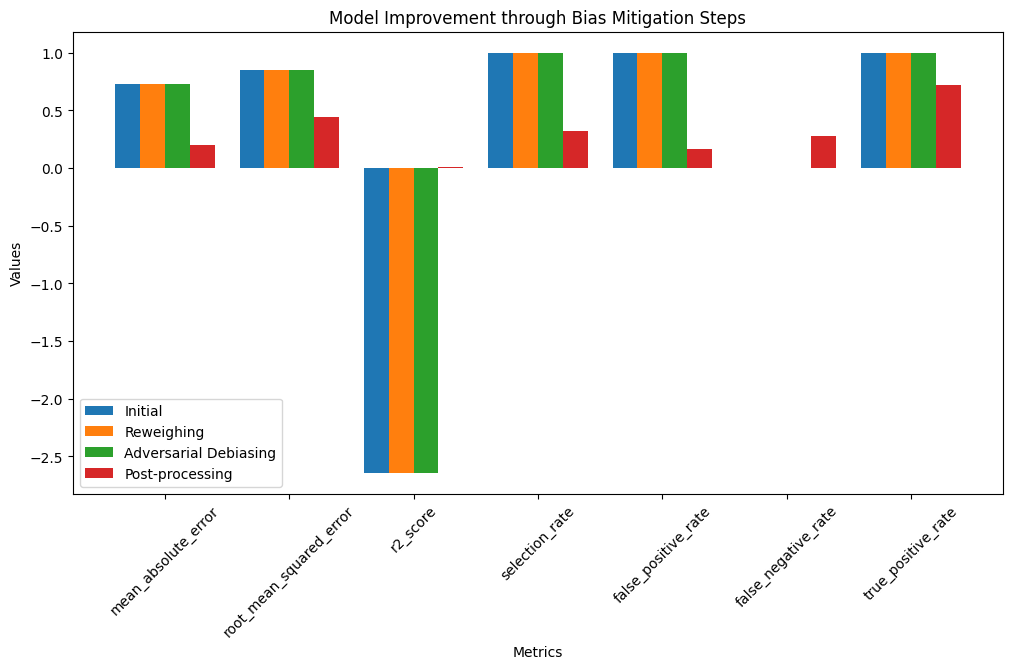

In [14]:
# Summary plot to show model improvement
def plot_model_improvement(summary_metrics):
    fig, ax = plt.subplots(figsize=(12, 6))
    labels = summary_metrics.index
    x = np.arange(len(labels))
    width = 0.2

    rects1 = ax.bar(x - width * 1.5, summary_metrics['Initial'], width, label='Initial')
    rects2 = ax.bar(x - width / 2, summary_metrics['Reweighing'], width, label='Reweighing')
    rects3 = ax.bar(x + width / 2, summary_metrics['Adversarial Debiasing'], width, label='Adversarial Debiasing')
    rects4 = ax.bar(x + width * 1.5, summary_metrics['Post-processing'], width, label='Post-processing')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title('Model Improvement through Bias Mitigation Steps')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend()

    plt.show()

# Creating a DataFrame to summarize overall metrics for final improvement plot
summary_metrics = pd.DataFrame({
    'Initial': overall_metrics_initial,
    'Reweighing': overall_metrics_rw,
    'Adversarial Debiasing': overall_metrics_ad,
    'Post-processing': overall_metrics_pp
})

# Plot model improvement summary
plot_model_improvement(summary_metrics)

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define additional custom metrics if not already defined
def false_omission_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return fn / (fn + tn) if (fn + tn) > 0 else np.nan

def true_negative_rate_custom(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else np.nan

def false_omission_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(false_omission_rate_custom(y_true[mask], y_pred[mask]))
    return np.nanmax(rates) - np.nanmin(rates)

def true_negative_rate_difference(y_true, y_pred, sensitive_features):
    groups = np.unique(sensitive_features)
    rates = []
    for group in groups:
        mask = (sensitive_features == group)
        rates.append(true_negative_rate_custom(y_true[mask], y_pred[mask]))
    return np.nanmax(rates) - np.nanmin(rates)


C:\Users\Fujitsu\AppData\Local\Temp\ipykernel_8260\4177998358.py:19: RuntimeWarning: All-NaN axis encountered
  return np.nanmax(rates) - np.nanmin(rates)


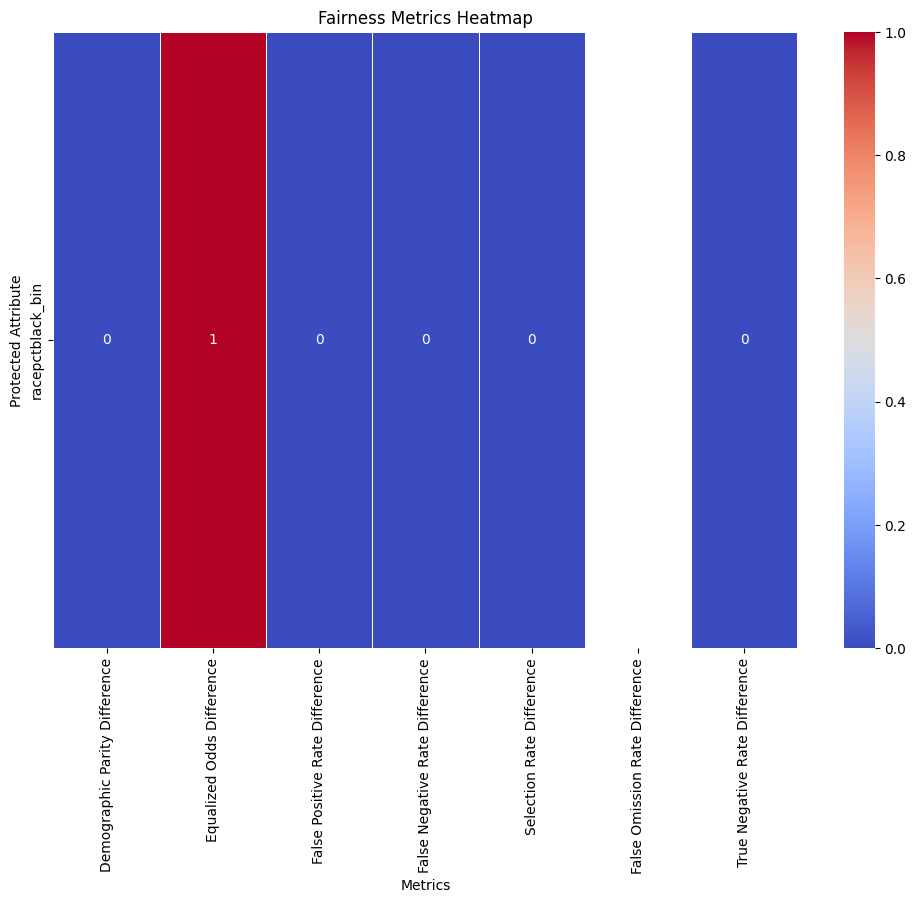

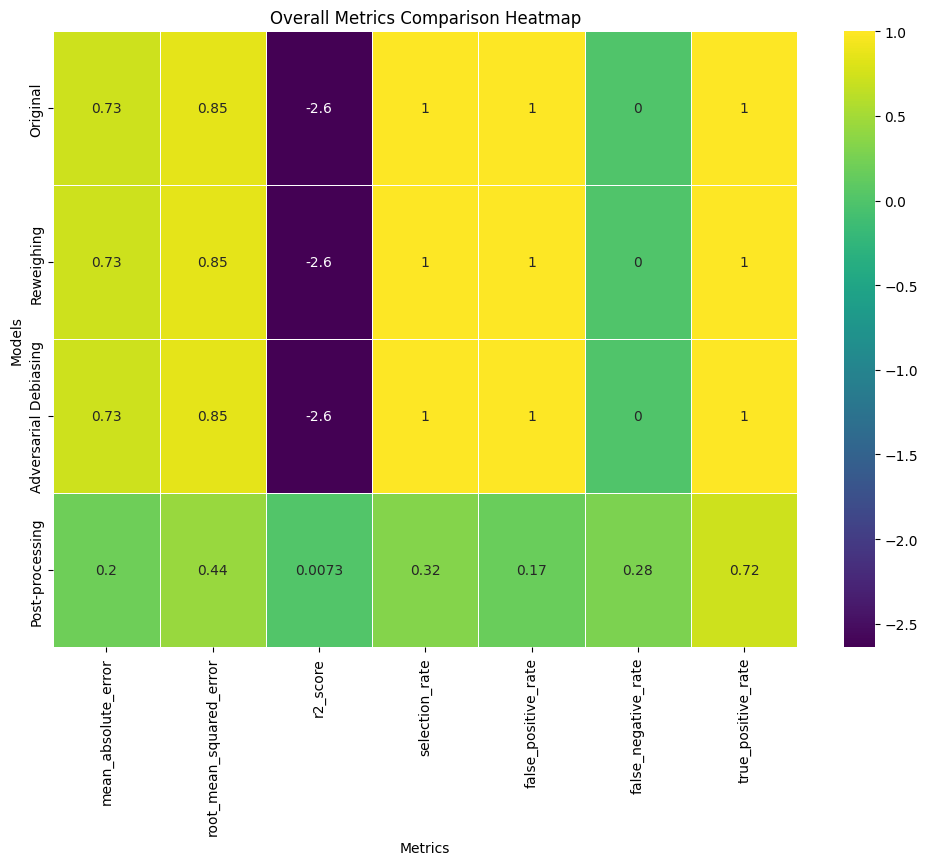

In [16]:
# Calculate fairness metrics if not already calculated
for_diff = false_omission_rate_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])
tnr_diff = true_negative_rate_difference(y_test, y_pred_binary, sensitive_features=data.loc[X_test.index, 'racepctblack_bin'])

# Summarize all fairness metrics
summary_metrics = {
    'Demographic Parity Difference': dpd,
    'Equalized Odds Difference': eod,
    'False Positive Rate Difference': fprd,
    'False Negative Rate Difference': fnrd,
    'Selection Rate Difference': srd,
    'False Omission Rate Difference': for_diff,
    'True Negative Rate Difference': tnr_diff
}

# Create heatmap for fairness metrics
metrics_heatmap_data = pd.DataFrame({
    'Demographic Parity Difference': [dpd],
    'Equalized Odds Difference': [eod],
    'False Positive Rate Difference': [fprd],
    'False Negative Rate Difference': [fnrd],
    'Selection Rate Difference': [srd],
    'False Omission Rate Difference': [for_diff],
    'True Negative Rate Difference': [tnr_diff]
}, index=['racepctblack_bin'])

plt.figure(figsize=(12, 8))
sns.heatmap(metrics_heatmap_data, annot=True, cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Fairness Metrics Heatmap')
plt.ylabel('Protected Attribute')
plt.xlabel('Metrics')
plt.show()

# Comparison heatmap for overall metrics
comparison_heatmap_data = pd.DataFrame({
    'Original': overall_metrics_initial,
    'Reweighing': overall_metrics_rw,
    'Adversarial Debiasing': overall_metrics_ad,
    'Post-processing': overall_metrics_pp
}).transpose()

plt.figure(figsize=(12, 8))
sns.heatmap(comparison_heatmap_data, annot=True, cmap='viridis', cbar=True, linewidths=0.5)
plt.title('Overall Metrics Comparison Heatmap')
plt.ylabel('Models')
plt.xlabel('Metrics')
plt.show()
